# Preparation

### Downloads

In [1]:
# Helps to collect tweets from twiter
!pip install tweepy

In [2]:
# Helps to remove stop words from sentences
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Mount Drive and Load Data

In [3]:
# load content from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# path of kaggle dataset
data_path = "/content/drive/MyDrive/Project/data.csv"
tweets_path = "/content/drive/MyDrive/Project/CollectedTweets.csv"
google_trends_path = "/content/drive/MyDrive/Project/GoogleTrends.csv"

### Imports

In [5]:
# Basic libraries
import pandas as pd
import numpy as np
import math
import seaborn as sns
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

In [6]:
# reading json file
import os
import glob
import json

In [7]:
# In order to clean and normaliaze the text
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split

In [8]:
# Collecting data from twitter
import tweepy
from datetime import date
from tweepy import OAuthHandler

In [9]:
# Evaluation
from sklearn.model_selection import KFold,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, accuracy_score

In [10]:
# for simple classification
from sklearn.dummy import DummyClassifier

In [11]:
# For the supervised learning - SVM + TD-IDF
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
# pre processing for deep learning
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [13]:
# for deep learning model - LSTM + Embedding
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers.embeddings import Embedding
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

# Question 1

### Data Loading

In [14]:
# load the Sentiment140 datset
df = pd.read_csv(data_path, encoding = "ISO-8859-1", names = ["target", "ids", "date", "flag", "user", "text"])

In [15]:
# get 100,000 samples from the data, in which 50% are positive and 50% are negative.
size = 50000
positive_df = df[df.target == 4][:size] # get first 50,000 positive tweets
negative_df = df[df.target == 0][:size] # get first 50,000 negative tweets
balanced_df = pd.concat([positive_df, negative_df]).reset_index(drop = True) # concatenation
balanced_df

,target,ids,date,flag,user,text
0,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
1,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
2,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
3,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
4,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone
...,...,...,...,...,...,...
99995,0,1678337109,Sat May 02 06:22:31 PDT 2009,NO_QUERY,Jessica_567,@mileycyrus so i have the same insomnia prob a...
99996,0,1678337116,Sat May 02 06:22:31 PDT 2009,NO_QUERY,whouwit077,20 mintues late for my meeting starting @ 8 h...
99997,0,1678337128,Sat May 02 06:22:31 PDT 2009,NO_QUERY,AmyPR,@kentucky_derby super excited! Are you tweetin...
99998,0,1678337159,Sat May 02 06:22:32 PDT 2009,NO_QUERY,cynthia_sue03,I WANT ANOTHER DAY OFF!!!! To much Sh#t to do...


### Pre-processing

In [16]:
# Regular expreesion for recognizing emoticons
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [dD\)\]\(\]/\\oOpP] # Mouth
    )"""

In [17]:
# Regular expressions for tweets terms, e.g: html tags, hashtags, @-mentions, URLs, numbers, etc.
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

In [18]:
# creating the regular expression
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

In [19]:
# tokenize the tweet according to the regular expressions - splits tweet to tokens
def tokenization(tweet):
  return tokens_re.findall(tweet)

In [20]:
# transform all letters to lower case
def lower_case(tokens): 
  tokens = [token.lower() for token in tokens]
  return tokens

In [21]:
# remove all URLS with http / https
def remove_html(tokens):
  new_token = []
  for token in tokens:
    if "http" not in token:
      new_token.append(token)
  return new_token

In [22]:
# remove tokens which contains only digits
def remove_digits(tokens):
  new_token = []
  for token in tokens:
    if not re.match(r'(?:(?:\d+,?)+(?:\.?\d+)?)',token):
      new_token.append(token)
  return new_token

In [23]:
# remove username mentions - tokens which start with @
def remove_users(tokens):
  new_token = []
  for token in tokens:
    if not re.match("@[\w]*", token):
      new_token.append(token)
  return new_token

In [24]:
# remove words with length <= 2 and not emoticons
def remove_short_words(tokens):
  new_tokens = []
  for token in tokens:
    if not (len(token)<=2 and len(emoticon_re.findall(token)) == 0):
      new_tokens.append(token)
  return new_tokens

In [25]:
# remove stop words and punctuations - the stop words list is without negative words that can influence the sentiment of the sentence 
def remove_stopwords(tokens):
  punctuation = list(string.punctuation)
  stop_words = set(stopwords.words('english') + punctuation + ['rt', 'via', 'the',u'\u2019',u'\u2026','The',u'de',u'\xe9'])
  
  negative_words = [word for word in stop_words if "'t" in word or word == 'not'] # remove negative words from stop words
  
  stop_words = [word for word in stop_words if word not in negative_words] + ["i'm", "im"] # remove negative words from stop words and adds the words "i'm", "im"
  
  filtered_tokens = [token for token in tokens if not token in stop_words and len(token) > 1] # getting non-stop words with length greater than 1 
  return filtered_tokens

In [26]:
snow_stem = SnowballStemmer('english')

# stemming tokens using snoball stemmer
def stemming(tokens):
    stem_tokens = []
    
    # stem each word
    for token in tokens:
        stem_tokens.append(snow_stem.stem(token))
    
    return stem_tokens

In [27]:
# encodes labels - 0 => 0 (Negative), 2 => doesn't exist (Neutral), 4 => 1 (Positive);
def label_encoding(label):
  if label == 4:
    return 1
  elif label == 0:
    return 0
  else:
    return -1

In [28]:
# Pre processing phase
def pre_processing(data):
  data.text = data.text.apply(tokenization)
  data.text = data.text.apply(lower_case)
  data.text = data.text.apply(remove_html)
  data.text = data.text.apply(remove_digits)
  data.text = data.text.apply(remove_users)
  data.text = data.text.apply(remove_stopwords)
  data.text = data.text.apply(remove_short_words)
  data.text = data.text.apply(stemming)
  if 'target' in data:
    data.target = data.target.apply(label_encoding)

In [29]:
tweet = " hi love you gus : ("
t = tokenization(tweet)
t = lower_case(t)
t = remove_html(t)
t = remove_digits(t)
t = remove_users(t)
t = remove_stopwords(t)
t = remove_short_words(t)
t = stemming(t)
t

['love', 'gus']

In [30]:
# copy dataset and pre process its text
df_copy = balanced_df.copy()
pre_processing(df_copy)

In [31]:
# remove empty rows after pre processing
for index, t in enumerate(df_copy.text):
  if len(t) == 0:
    df_copy.drop(index, inplace=True)
df_copy.reset_index(inplace=True)

In [32]:
df_copy[["text","target"]]

,text,target
0,"[love, guy, best]",1
1,"[meet, one, besti, tonight, cant, wait, girl, ...",1
2,"[thank, twitter, add, sunisa, got, meet, hin, ...",1
3,"[sick, realli, cheap, hurt, much, eat, real, f...",1
4,"[effect, everyon]",1
...,...,...
99500,"[insomnia, prob, slept, hrs, woke, couldnt, ba...",0
99501,"[mintu, late, meet, start, how'd, know, go, la...",0
99502,"[super, excit, tweet, event, happen, way, foll...",0
99503,"[want, anoth, day, much, today, got, quot, new...",0


### Data Exploration

In [33]:
# show sentiment distribution plot
def class_dist(data):
  target_cnt = data.target.value_counts() # count number of samples for each sentiment 
  plt.figure(figsize=(16,8))
  plt.bar(["Negative", "Positive"], [target_cnt.values[0]/data.shape[0], target_cnt.values[1]/data.shape[0]])
  plt.title("Dataset class distribuition")
  plt.show()

In [34]:
# for report
print(f"Negative distribution:  {df_copy.target.value_counts()[0] / df_copy.shape[0]}")
print(f"Positive distribution:  {df_copy.target.value_counts()[1] / df_copy.shape[0]}")

Negative distribution:  0.5003869152303905
Positive distribution:  0.4996130847696096


In [35]:
# count frequencies of words for each sentiment
def count_terms(data):
  count_all_positive = Counter()
  count_all_negative = Counter()

  for index, text in enumerate(data.text):
    if data.iloc[index].target == 0:
      count_all_negative.update(text)
    else:
      count_all_positive.update(text)
  return count_all_positive, count_all_negative

In [36]:
# table of top_n terms per category
def top_terms(count_positive, count_negative, top_n):
    positive_data = [list(x) for x in count_positive.most_common(top_n)]
    print(f"Top {top_n} positive terms")
    draw_table(positive_data, 'Positive')
    
    negative_data = [list(x) for x in count_negative.most_common(top_n)]
    print(f"Top {top_n} negative terms")
    draw_table(negative_data, 'Negative')

# draw table of top_n terms
def draw_table(data, type):
    fig = plt.figure(dpi=80)
    ax = fig.add_subplot(1,1,1)
    table = ax.table(cellText=data, loc='center',colLabels=[f'{type} term','Frequency'])
    table.set_fontsize(14)
    table.scale(1,2)
    ax.axis('off')
    plt.show()

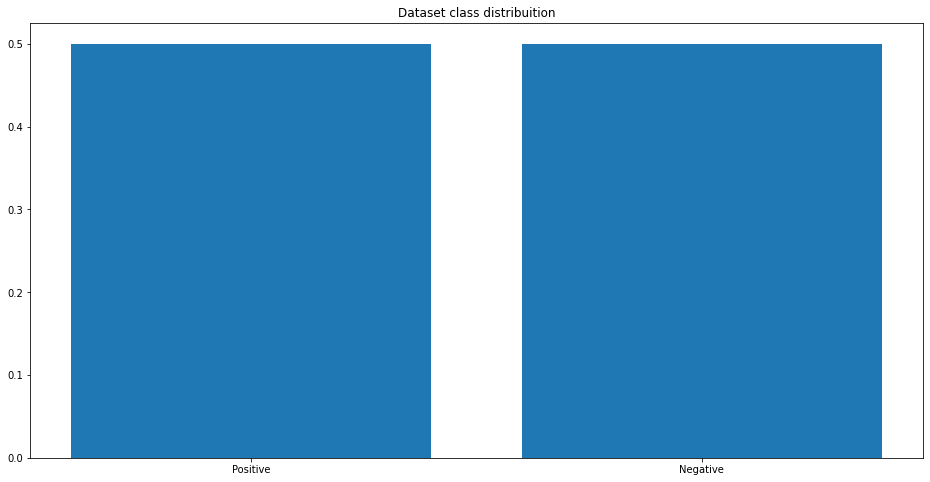

Top 10 positive terms


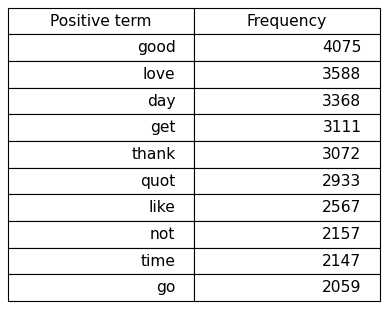

Top 10 negative terms


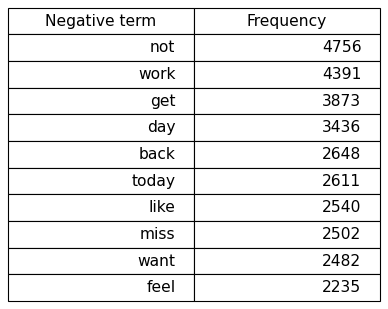

In [37]:
# plot sentiment distribution and tables of top 10 sentiment terms
class_dist(df_copy)
top_terms(*count_terms(df_copy), 10)

### Data Splitting - Train & Test sets

In [38]:
# concatenate tokens into sentences in order to use feature extraction libraries
def join_sentences(text):
  return ' '.join(text)

In [39]:
# copy dataset and concatenate tokens to sentences
df_copy2 = df_copy.copy()
df_copy2.text = df_copy2.text.apply(join_sentences)

# split target and data
y = df_copy2.target
X = df_copy2.iloc[:,1:] # without target column

# Split data into training and test sets - 50% percent for train and 50% percent for test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size = 0.5, 
                                                    random_state=0)

In [40]:
# Check imbalanced data
print(f'Positive train samples: {y_train[y_train == 1].shape}')
print(f'Negative train samples: {y_train[y_train == 0].shape}')

Positive train samples: (24923,)
Negative train samples: (24829,)


# Question 2

### Dummy Classifier

In [41]:
# Dummy classifier - classifies sampels according to most frequent label - for testing (baseline).
# In order to see that our model is better than dummy model.
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_accuracy_train = dummy_clf.score(X_train, y_train)
dummy_accuracy_test = dummy_clf.score(X_test, y_test)
print(f"Dummy Classifier Train Accuracy: {dummy_accuracy_train}")
print(f"Dummy Classifier Test Accuracy: {dummy_accuracy_test}")

Dummy Classifier Train Accuracy: 0.5009446856407782
Dummy Classifier Test Accuracy: 0.4982815106626736


### Machine learning model - SVM + TF-IDF

In [42]:
# Using the best model from the previous assignment. The best model - SVM + TF-IDF
tf = TfidfVectorizer()
svm = LinearSVC()

In [43]:
# model parameters to tune
svm_tf_params = {"clf__loss": ['hinge'],
              "clf__random_state": [0],
              "clf__C": [1,2],
              "vect__ngram_range": [(1,1),(1,2)]}

### Deep learning approach - LSTM

In [44]:
# get the vocabulary size of the data using tokenizer class
tokenizer = Tokenizer() 
def get_vocab_size():
  tokenizer.fit_on_texts(X_train.text)
  word_index = tokenizer.word_index
  vocab_size = len(tokenizer.word_index) + 1
  return vocab_size

In [45]:
# get the length of longest tweet
def get_max_length_tweet():
  max_length = max([len(text) for text in X_train.text])
  return max_length

In [46]:
# parameters to use
embedding_vecor_length = 128
vocab_size = get_vocab_size()
max_length = get_max_length_tweet()

In [47]:
# padding text with 0 
def pad_text(data):
  pad_data = pad_sequences(tokenizer.texts_to_sequences(data),
                          maxlen = max_length)
  return pad_data

In [48]:
#create deep learning model
def create_model(dropout_rate=0.2):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_length))
  model.add(LSTM(embedding_vecor_length, dropout = dropout_rate))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model

In [49]:
# build lstm model using keras classifier in order to use grid search
lstm = KerasClassifier(build_fn=create_model, verbose=1)

In [50]:
# parameters to tune
lstm_params = {"batch_size":[256],
               "epochs": [5],
               "dropout_rate": [0.2,0.4]}

### Cross validation

In [51]:
# 10 fold cross validation
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

### Grid search - parameters tuning

In [52]:
# Grid search in order to find the best combination for each model
def grid_search(model, model_name, parameters, x, y, k_fold, deep = False):
    print("=" * 80)
    print(f"Model: {model_name}")
    if not deep:
      print(f"Featrue extraction method: TF-IDF")
      nb_clf = Pipeline([('vect', tf),('clf', model)])
      gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=1, cv=k_fold, verbose = 1)
    else:
      gs_clf = GridSearchCV(model, parameters, n_jobs=1, cv=2, verbose = 1)
    print("_" * 80)
    gs_clf = gs_clf.fit(x, y)
    print('Best score: ', gs_clf.best_score_)
    print('Best params: ', gs_clf.best_params_)
    return gs_clf.best_estimator_

In [53]:
# Testing the impact of changing parameters of machine learning / deep learning model on classification result
models = [(lstm,"LSTM"), (svm, "SVM")]
parameters = { "SVM": svm_tf_params, "LSTM": lstm_params}
best_models = {}

for model, model_name in models:
  if model_name == "SVM":
    best_model = grid_search(model, model_name, parameters[model_name], X_train.text, y_train, k_fold)
  else:
    x_data = pad_text(X_train.text)
    best_model = grid_search(model, model_name, parameters[model_name], x_data, y_train, k_fold=None, deep = True)

  best_models[model_name] =  best_model

Model: LSTM
________________________________________________________________________________
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 135, 128)          3442048   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,573,761
Trainable params: 3,573,761
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
98/98 [==============================] - 9s 58ms/step - loss: 0.6477 - accuracy: 0.6092
Epoch 2/5
98/98 [==============================] - 5s 55ms/step - loss: 0.4317 - accuracy: 0.8067
Epoch 3/5
98/98 [==============================] - 5s 55ms/step - loss: 0.3510 - accuracy: 0.8519
Epoch 4/5
98/98 [==============================] - 5s 55ms/step - loss: 0.288

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.1min finished


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 135, 128)          3442048   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 3,573,761
Trainable params: 3,573,761
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
195/195 [==============================] - 12s 55ms/step - loss: 0.6080 - accuracy: 0.6546
Epoch 2/5
195/195 [==============================] - 10s 53ms/step - loss: 0.4287 - accuracy: 0.8082
Epoch 3/5
195/195 [==============================] - 11s 54ms/step - loss: 0.3757 - accuracy: 0.8371
Epoch 4/5
195/195 [==============================] - 11s 54ms/step

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, 

Best score:  0.7720695196238426
Best params:  {'clf__C': 1, 'clf__loss': 'hinge', 'clf__random_state': 0, 'vect__ngram_range': (1, 2)}


### Evaluation - Accuracy

##### ML model evaluation

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     24962
           1       0.78      0.76      0.77     24791

    accuracy                           0.77     49753
   macro avg       0.77      0.77      0.77     49753
weighted avg       0.77      0.77      0.77     49753



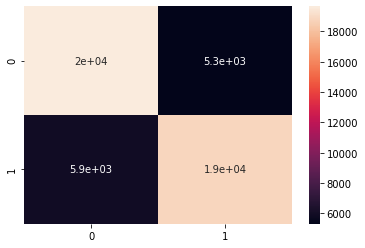

In [54]:
# using svm model with the best hyperparameters from the grid search on the test set
svm_model = best_models["SVM"]

svm_train_prediction = svm_model.predict(X_train.text)
svm_accuracy_train = accuracy_score(y_train, svm_train_prediction)

svm_test_prediction = svm_model.predict(X_test.text)
svm_accuracy_test = accuracy_score(y_test, svm_test_prediction)

print(classification_report(y_test, svm_test_prediction))
svm_cm = confusion_matrix(y_test, svm_test_prediction)
sns.heatmap(svm_cm, annot=True)
print("=====================")

##### DL model evaluation

195/195 [==============================] - 2s 11ms/step - loss: 0.5756 - accuracy: 0.7520


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


195/195 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

           0       0.76      0.74      0.75     24962
           1       0.75      0.76      0.75     24791

    accuracy                           0.75     49753
   macro avg       0.75      0.75      0.75     49753
weighted avg       0.75      0.75      0.75     49753



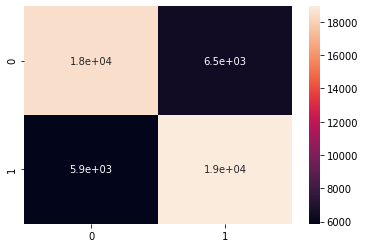

In [55]:
# using lstm model with the best hyperparameters from the grid search on the test set
dl_model = best_models["LSTM"]

x_train_data = pad_text(X_train.text)
lstm_accuracy_train = dl_model.score(x_train_data, y_train)

x_test_data = pad_text(X_test.text)
lstm_accuracy_test = dl_model.score(x_test_data, y_test)

lstm_prediction = dl_model.predict(x_test_data)
print(classification_report(y_test, lstm_prediction))
lstm_cm = confusion_matrix(y_test,lstm_prediction)
sns.heatmap(lstm_cm, annot=True)
print("=====================")

### Can you use the model from homework \#2 without re-training?
No, we cannot becuase the vocabulary of the model is different. In the previous homework we used an imdb dataset which contains reviews about movies, and in the current project we use tweets which contains hashtags, urls, emojis, @-usernames etc. Thus, even if we use a pre-trained model we still need to fit the model to our data.

### Comparison

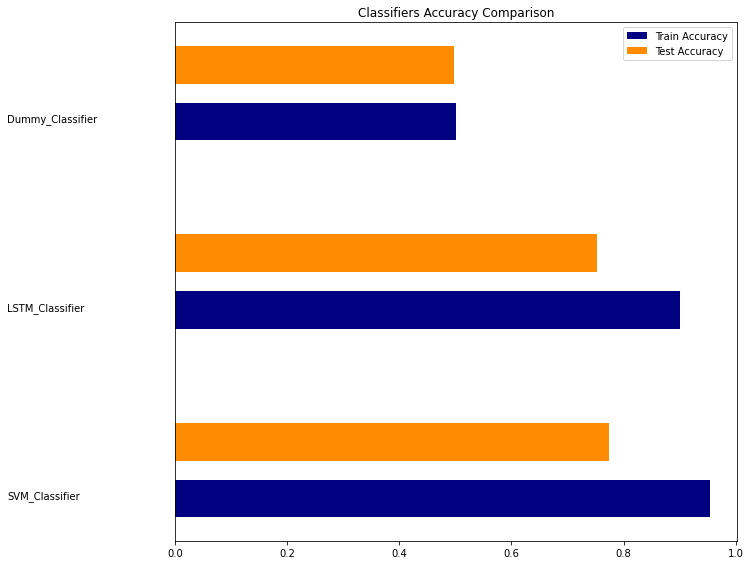

In [56]:
# plot horizontal graph to compare models accuracy - comparing between train and test accuracy
def plot_results():
  indices = np.arange(3)

  results = [["SVM_Classifier","LSTM_Classifier", "Dummy_Classifier"],
             [svm_accuracy_train, lstm_accuracy_train, dummy_accuracy_train],
             [svm_accuracy_test, lstm_accuracy_test, dummy_accuracy_test]]

  clf_names, train_score, test_score = results

  plt.figure(figsize=(12, 8))
  plt.title("Classifiers Accuracy Comparison")
  plt.barh(indices, train_score, .2, label="Train Accuracy", color='navy')
  plt.barh(indices + .3, test_score, .2, label="Test Accuracy", color='darkorange')
  plt.yticks(())
  plt.legend(loc='best')
  plt.subplots_adjust(left=.25)
  plt.subplots_adjust(top=.95)
  plt.subplots_adjust(bottom=.05)

  for i, c in zip(indices, clf_names):
      plt.text(-.3, i, c)

  plt.show()

plot_results()

### Discussion
As we can see, both models performed better than a simple model which classifies samples according to the most frequent label of the train set. We guess that most of the sentiment classification errors were on tweets which include words that are common on both sentiment classes, e.g the words "day", "get", etc.

In addition, the SVM model performed better than the LSTM model, but we suspect that if we would train the network for more epochs and would use a pre-trained weights, e.g gensim library, we could improve the performance of the LSTM model, but our computational power is very limited.


# Question 3



### Collect Twitter Data

In [57]:
# twitter params
consumer_key = '9CVpD09XNP8bq1FS5WZomnumR'
consumer_secret = 'oDIcvrU5TQBzrMcDrxQVPUcgrH7SGDQgqvapbBGEGIW9pB0WVH'
access_token = '1350938591090900992-XUkzPkYDfnTLg2nJjGbpOUKqRLc8no'
access_secret = '2Qrnj3JJAUri0eCavx2eAhZpaIow2PNrdYefClwJBjp5T'

In [58]:
# get twitter access through tweepyAPI
auth = OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_secret)
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [59]:
#override tweepy.StreamListener to add logic to on_status
class MyStreamListener(tweepy.StreamListener):
  def on_data(self, data):
    try:
      
      with open('Baiden.json', 'a') as f:
        
        if "retweeted_status" in data: # does not collect retweets 
          return True
        
        else:
          f.write(data)
          return True
    
    except BaseException as e:
      print("Error on_data: %s" % str(e))
    
    return True

  def on_error(self, status):
    print(status)
    return True

In [60]:
# creating streaming listener
# myStreamListener = MyStreamListener()
# myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)

In [61]:
# collecting data from twitter through streaming API
# myStream.filter(track=['JoeBiden', 'Joe Biden'], languages=['en'])

### Extract Tweets from json to CSV

In [62]:
'''
# import tweets
all_data = []
dates = []
hours = []
texts = []

#open new directory for tweets per dates files
if not os.path.exists('Tweets-Biden'):
    os.makedirs('Tweets-Biden')
    
# files path should be a directory with the tweets's files per day
def tweets_per_day(files_path,start_hour):
    tweets_files = glob.glob(files_path + "\\*.txt")
    for date_file in tweets_files:
        with open(date_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                try:
                    if len(line) > 1:
                        twit_data = json.loads(line)
                        dt_object = datetime.fromtimestamp(int(twit_data['timestamp_ms'])/1000)
                        if dt_object.hour >= start_hour and dt_object.hour < start_hour +1:
                            date = dt_object.strftime("%Y-%m-%d, %H:%M:%S")
                            all_data.append(twit_data)
#                             names.append(twit_data['user']['name'])
                            date_split = date.split(", ")
                            dates.append(date_split[0])
                            hours.append(date_split[1])
                            texts.append(twit_data['text'])
                except Exception as e:
                    print(line)
                    raise e
    return True

tweets_per_day("C:\\Users\\noyha\\PycharmProjects\\final_project_pwmba\\Tweets-Biden",18)
tweetsDf = pd.DataFrame({'date': dates, 'hour: hours,'text': texts})
'''

'\n# import tweets\nall_data = []\ndates = []\nhours = []\ntexts = []\n\n#open new directory for tweets per dates files\nif not os.path.exists(\'Tweets-Biden\'):\n    os.makedirs(\'Tweets-Biden\')\n    \n# files path should be a directory with the tweets\'s files per day\ndef tweets_per_day(files_path,start_hour):\n    tweets_files = glob.glob(files_path + "\\*.txt")\n    for date_file in tweets_files:\n        with open(date_file, \'r\') as f:\n            lines = f.readlines()\n            for line in lines:\n                try:\n                    if len(line) > 1:\n                        twit_data = json.loads(line)\n                        dt_object = datetime.fromtimestamp(int(twit_data[\'timestamp_ms\'])/1000)\n                        if dt_object.hour >= start_hour and dt_object.hour < start_hour +1:\n                            date = dt_object.strftime("%Y-%m-%d, %H:%M:%S")\n                            all_data.append(twit_data)\n#                             names.append(

In [63]:
'''
emoticons_positive = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-d', ':d', '8-d', '8d', 'x-d', 'xd', 'x-d', 'xd', '=-d', '=d',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:p', ':-p', ':p', 'x-p',
    'x-p', 'xp', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)', ': )',
    '<3'])
emoticons_negative = set([
    ':L', ':-/', '>:/', ':s', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
'''

'\nemoticons_positive = set([\n    \':-)\', \':)\', \';)\', \':o)\', \':]\', \':3\', \':c)\', \':>\', \'=]\', \'8)\', \'=)\', \':}\',\n    \':^)\', \':-d\', \':d\', \'8-d\', \'8d\', \'x-d\', \'xd\', \'x-d\', \'xd\', \'=-d\', \'=d\',\n    \'=-3\', \'=3\', \':-))\', ":\'-)", ":\')", \':*\', \':^*\', \'>:p\', \':-p\', \':p\', \'x-p\',\n    \'x-p\', \'xp\', \':-p\', \':p\', \'=p\', \':-b\', \':b\', \'>:)\', \'>;)\', \'>:-)\', \': )\',\n    \'<3\'])\nemoticons_negative = set([\n    \':L\', \':-/\', \'>:/\', \':s\', \'>:[\', \':@\', \':-(\', \':[\', \':-||\', \'=L\', \':<\',\n    \':-[\', \':-<\', \'=\\\', \'=/\', \'>:(\', \':(\', \'>.<\', ":\'-(", ":\'(", \':\\\', \':-c\',\n    \':c\', \':{\', \'>:\\\', \';(\'\n    ])\n'

In [64]:
'''
# find tweets with emoticons
tweetsDf['target'] = -1

def check_emoticons(row):
  pos_emoticons = 0
  neg_emoticons = 0
  for word in row.split(" "):
    if word in emoticons_negative:
      neg_emoticons = neg_emoticons + 1
      break
    if word in emoticons_positive:
      pos_emoticons = pos_emoticons + 1
      break
      
  if pos_emoticons > neg_emoticons:
      return 1
  elif pos_emoticons < neg_emoticons:
      return 0
  else:
      return -1

tweetsDf['target'] = tweetsDf['text'].apply(check_emoticons)
print(f"Num of positive tweets {len(tweetsDf.loc[tweetsDf['target'] == 1])}")
print(f"Num of negative tweets {len(tweetsDf.loc[tweetsDf['target'] == 0])}")
print(f"Num of natural tweets {len(tweetsDf.loc[tweetsDf['target'] == -1])}")
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(tweetsDf['target'])
'''

'\n# find tweets with emoticons\ntweetsDf[\'target\'] = -1\n\ndef check_emoticons(row):\n  pos_emoticons = 0\n  neg_emoticons = 0\n  for word in row.split(" "):\n    if word in emoticons_negative:\n      neg_emoticons = neg_emoticons + 1\n      break\n    if word in emoticons_positive:\n      pos_emoticons = pos_emoticons + 1\n      break\n      \n  if pos_emoticons > neg_emoticons:\n      return 1\n  elif pos_emoticons < neg_emoticons:\n      return 0\n  else:\n      return -1\n\ntweetsDf[\'target\'] = tweetsDf[\'text\'].apply(check_emoticons)\nprint(f"Num of positive tweets {len(tweetsDf.loc[tweetsDf[\'target\'] == 1])}")\nprint(f"Num of negative tweets {len(tweetsDf.loc[tweetsDf[\'target\'] == 0])}")\nprint(f"Num of natural tweets {len(tweetsDf.loc[tweetsDf[\'target\'] == -1])}")\n# with pd.option_context(\'display.max_rows\', None, \'display.max_columns\', None):  # more options can be specified also\n#     print(tweetsDf[\'target\'])\n'

In [65]:
'''
 tweetsDf = tweetsDf.drop_duplicates(subset=['text'])

# count number of tweets at each day
def count_daily_tweets():
  count_tweets_per_day = {}
  for index,row in tweetsDf.iterrows():
      date = row['date']
      if date in count_tweets_per_day:
        count_tweets_per_day[date] = count_tweets_per_day[date] + 1
      else:
        count_tweets_per_day[date] = 1
    return count_tweets_per_day
'''

"\n tweetsDf = tweetsDf.drop_duplicates(subset=['text'])\n\n# count number of tweets at each day\ndef count_daily_tweets():\n  count_tweets_per_day = {}\n  for index,row in tweetsDf.iterrows():\n      date = row['date']\n      if date in count_tweets_per_day:\n        count_tweets_per_day[date] = count_tweets_per_day[date] + 1\n      else:\n        count_tweets_per_day[date] = 1\n    return count_tweets_per_day\n"

In [66]:
'''
# calculates original distribution in order to take 15,000 tweets.
limit_number = 15000
total_biden_tweets = sum(count_tweets_per_day.values())
normelized_paramter = limit_number/total_biden_tweets
count_tweets_per_day = count_daily_tweets()
for day in count_tweets_per_day:
  count_tweets_per_day[day] = int(count_tweets_per_day[day] * normelized_paramter)
  total_biden_tweets = sum(count_tweets_per_day.values()) 
  for day in count_tweets_per_day:
      if total_biden_tweets < limit_number:
          count_tweets_per_day[day] = count_tweets_per_day[day] + 1
          total_biden_tweets = sum(count_tweets_per_day.values())
  print(count_tweets_per_day)

print(total_biden_tweets)            
print(count_tweets_per_day) 
'''

'\n# calculates original distribution in order to take 15,000 tweets.\nlimit_number = 15000\ntotal_biden_tweets = sum(count_tweets_per_day.values())\nnormelized_paramter = limit_number/total_biden_tweets\ncount_tweets_per_day = count_daily_tweets()\nfor day in count_tweets_per_day:\n  count_tweets_per_day[day] = int(count_tweets_per_day[day] * normelized_paramter)\n  total_biden_tweets = sum(count_tweets_per_day.values()) \n  for day in count_tweets_per_day:\n      if total_biden_tweets < limit_number:\n          count_tweets_per_day[day] = count_tweets_per_day[day] + 1\n          total_biden_tweets = sum(count_tweets_per_day.values())\n  print(count_tweets_per_day)\n\nprint(total_biden_tweets)            \nprint(count_tweets_per_day) \n'

In [67]:
'''
# takes only 15,000 tweets according to the original distribution - takes all tweets with emojis 
collected_tweets = pd.DataFrame()
for day in count_tweets_per_day:
    emoji_df = tweetsDf[(tweetsDf.date == day) & ((tweetsDf.target == 1) | (tweetsDf.target == 0))][:] 
    day_df = tweetsDf[(tweetsDf.date == day) & (tweetsDf.target == -1)][:(count_tweets_per_day[day]-emoji_df.shape[0])] 
    collected_tweets = pd.concat([collected_tweets, day_df, emoji_df]).reset_index(drop = True) # concatenation
collected_tweets.to_csv("Collected Tweets.csv", index=False)
'''

'\n# takes only 15,000 tweets according to the original distribution - takes all tweets with emojis \ncollected_tweets = pd.DataFrame()\nfor day in count_tweets_per_day:\n    emoji_df = tweetsDf[(tweetsDf.date == day) & ((tweetsDf.target == 1) | (tweetsDf.target == 0))][:] \n    day_df = tweetsDf[(tweetsDf.date == day) & (tweetsDf.target == -1)][:(count_tweets_per_day[day]-emoji_df.shape[0])] \n    collected_tweets = pd.concat([collected_tweets, day_df, emoji_df]).reset_index(drop = True) # concatenation\ncollected_tweets.to_csv("Collected Tweets.csv", index=False)\n'

### Import Tweets to Dataframe

In [68]:
# import tweets from collected tweets dataset - has no duplicates
tweetsDf = pd.read_csv(tweets_path)
tweetsDf['date'] = pd.to_datetime(tweetsDf['date'])
tweetsDf

,date,hour,text
0,2021-02-06,18:00:00,174 organizations and businesses urge Biden to...
1,2021-02-06,18:00:00,Sign the card now to let President Joe Biden a...
2,2021-02-06,18:00:01,@mtgreenee @JoeBiden Ukraine receiving aid had...
3,2021-02-06,18:00:01,President Joe Biden took office last month wit...
4,2021-02-06,18:00:01,Joe Biden’s calls for unity are disingenuous. ...
...,...,...,...
14995,2021-02-12,18:57:49,You didn’t mention the biggest issue facing al...
14996,2021-02-12,18:58:06,@donie @VanityFair We expect and deserve a hig...
14997,2021-02-12,18:58:12,@Kaychaz8 @AnonRats @UnknownSoldier @drjasonni...
14998,2021-02-12,18:59:01,@CeciliaBeverley @a_leigh_n @SenRonJohnson @Jo...


### Pre processing


In [69]:
# pre process the data 
tweetsDf_copy = tweetsDf.copy()
pre_processing(tweetsDf_copy)
tweetsDf_copy

,date,hour,text
0,2021-02-06,18:00:00,"[organ, busi, urg, biden, cancel, immigr, ban]"
1,2021-02-06,18:00:00,"[sign, card, let, presid, joe, biden, vice, pr..."
2,2021-02-06,18:00:01,"[ukrain, receiv, aid, prereq, met, part, obama..."
3,2021-02-06,18:00:01,"[presid, joe, biden, took, offic, last, month,..."
4,2021-02-06,18:00:01,"[joe, biden, call, uniti, disingenu, execut, o..."
...,...,...,...
14995,2021-02-12,18:57:49,"[mention, biggest, issu, face, climat, chang, ..."
14996,2021-02-12,18:58:06,"[expect, deserv, higher, standard, joe, biden,..."
14997,2021-02-12,18:58:12,"[would, shoot, cong]"
14998,2021-02-12,18:59:01,"[explain, exact, antifa]"


### Sentiment Classification

##### Classification by Emoticons

In [70]:
# sets of positive and negative emoticons
emoticons_positive = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-d', ':d', '8-d', '8d', 'x-d', 'xd', '=-d', '=d',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:p', ':-p', ':p',
    'x-p', 'xp', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)','<3'])
emoticons_negative = set([
    ':l', ':-/', '>:/', ':s', '>:[', ':@', ':-(', ':[', ':-||', '=l', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';(', ':-('])

In [71]:
# check if tweet has positive or negative emoticons
def check_emoticons(row):
  pos_emoticons = 0
  neg_emoticons = 0
  for word in row:
    if word in emoticons_negative:
      neg_emoticons = neg_emoticons + 1
      break
    if word in emoticons_positive:
      pos_emoticons = pos_emoticons + 1
      break
      
  if pos_emoticons > neg_emoticons:
      return 1
  elif pos_emoticons < neg_emoticons:
      return 0
  else:
      return -1

In [72]:
tweetsDf_copy['target'] = -1 # initialize serntiments to -1
tweetsDf_copy['target'] = tweetsDf_copy['text'].apply(check_emoticons)
print(f"Num of positive tweets {len(tweetsDf_copy.loc[tweetsDf_copy['target'] == 1])}")
print(f"Num of negative tweets {len(tweetsDf_copy.loc[tweetsDf_copy['target'] == 0])}")
print(f"Num of natural tweets {len(tweetsDf_copy.loc[tweetsDf_copy['target'] == -1])}")

Num of positive tweets 20
Num of negative tweets 3
Num of natural tweets 14977


##### Classification by Neg and Pos Words

In [73]:
# word dictionaries of positive and negative words 
negative_words = {'2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted', 'aborts', 'abrade', 'abrasive', 'abrupt', 'abruptly', 'abscond', 'absence', 'absent-minded', 'absentee', 'absurd', 'absurdity', 'absurdly', 'absurdness', 'abuse', 'abused', 'abuses', 'abusive', 'abysmal', 'abysmally', 'abyss', 'accidental', 'accost', 'accursed', 'accusation', 'accusations', 'accuse', 'accuses', 'accusing', 'accusingly', 'acerbate', 'acerbic', 'acerbically', 'ache', 'ached', 'aches', 'achey', 'aching', 'acrid', 'acridly', 'acridness', 'acrimonious', 'acrimoniously', 'acrimony', 'adamant', 'adamantly', 'addict', 'addicted', 'addicting', 'addicts', 'admonish', 'admonisher', 'admonishingly', 'admonishment', 'admonition', 'adulterate', 'adulterated', 'adulteration', 'adulterier', 'adversarial', 'adversary', 'adverse', 'adversity', 'afflict', 'affliction', 'afflictive', 'affront', 'afraid', 'aggravate', 'aggravating', 'aggravation', 'aggression', 'aggressive', 'aggressiveness', 'aggressor', 'aggrieve', 'aggrieved', 'aggrivation', 'aghast', 'agonies', 'agonize', 'agonizing', 'agonizingly', 'agony', 'aground', 'ail', 'ailing', 'ailment', 'aimless', 'alarm', 'alarmed', 'alarming', 'alarmingly', 'alienate', 'alienated', 'alienation', 'allegation', 'allegations', 'allege', 'allergic', 'allergies', 'allergy', 'aloof', 'altercation', 'ambiguity', 'ambiguous', 'ambivalence', 'ambivalent', 'ambush', 'amiss', 'amputate', 'anarchism', 'anarchist', 'anarchistic', 'anarchy', 'anemic', 'anger', 'angrily', 'angriness', 'angry', 'anguish', 'animosity', 'annihilate', 'annihilation', 'annoy', 'annoyance', 'annoyances', 'annoyed', 'annoying', 'annoyingly', 'annoys', 'anomalous', 'anomaly', 'antagonism', 'antagonist', 'antagonistic', 'antagonize', 'anti-', 'anti-american', 'anti-israeli', 'anti-occupation', 'anti-proliferation', 'anti-semites', 'anti-social', 'anti-us', 'anti-white', 'antipathy', 'antiquated', 'antithetical', 'anxieties', 'anxiety', 'anxious', 'anxiously', 'anxiousness', 'apathetic', 'apathetically', 'apathy', 'apocalypse', 'apocalyptic', 'apologist', 'apologists', 'appal', 'appall', 'appalled', 'appalling', 'appallingly', 'apprehension', 'apprehensions', 'apprehensive', 'apprehensively', 'arbitrary', 'arcane', 'archaic', 'arduous', 'arduously', 'argumentative', 'arrogance', 'arrogant', 'arrogantly', 'ashamed', 'asinine', 'asininely', 'asinininity', 'askance', 'asperse', 'aspersion', 'aspersions', 'assail', 'assassin', 'assassinate', 'assault', 'assult', 'astray', 'asunder', 'atrocious', 'atrocities', 'atrocity', 'atrophy', 'attack', 'attacks', 'audacious', 'audaciously', 'audaciousness', 'audacity', 'audiciously', 'austere', 'authoritarian', 'autocrat', 'autocratic', 'avalanche', 'avarice', 'avaricious', 'avariciously', 'avenge', 'averse', 'aversion', 'aweful', 'awful', 'awfully', 'awfulness', 'awkward', 'awkwardness', 'ax', 'babble', 'back-logged', 'back-wood', 'back-woods', 'backache', 'backaches', 'backaching', 'backbite', 'backbiting', 'backward', 'backwardness', 'backwood', 'backwoods', 'bad', 'badly', 'baffle', 'baffled', 'bafflement', 'baffling', 'bait', 'balk', 'banal', 'banalize', 'bane', 'banish', 'banishment', 'bankrupt', 'barbarian', 'barbaric', 'barbarically', 'barbarity', 'barbarous', 'barbarously', 'barren', 'baseless', 'bash', 'bashed', 'bashful', 'bashing', 'bastard', 'bastards', 'battered', 'battering', 'batty', 'bearish', 'beastly', 'bedlam', 'bedlamite', 'befoul', 'beg', 'beggar', 'beggarly', 'begging', 'beguile', 'belabor', 'belated', 'beleaguer', 'belie', 'belittle', 'belittled', 'belittling', 'bellicose', 'belligerence', 'belligerent', 'belligerently', 'bemoan', 'bemoaning', 'bemused', 'bent', 'berate', 'bereave', 'bereavement', 'bereft', 'berserk', 'beseech', 'beset', 'besiege', 'besmirch', 'bestial', 'betray', 'betrayal', 'betrayals', 'betrayer', 'betraying', 'betrays', 'bewail', 'beware', 'bewilder', 'bewildered', 'bewildering', 'bewilderingly', 'bewilderment', 'bewitch', 'bias', 'biased', 'biases', 'bicker', 'bickering', 'bid-rigging', 'bigotries', 'bigotry', 'bitch', 'bitchy', 'biting', 'bitingly', 'bitter', 'bitterly', 'bitterness', 'bizarre', 'blab', 'blabber', 'blackmail', 'blah', 'blame', 'blameworthy', 'bland', 'blandish', 'blaspheme', 'blasphemous', 'blasphemy', 'blasted', 'blatant', 'blatantly', 'blather', 'bleak', 'bleakly', 'bleakness', 'bleed', 'bleeding', 'bleeds', 'blemish', 'blind', 'blinding', 'blindingly', 'blindside', 'blister', 'blistering', 'bloated', 'blockage', 'blockhead', 'bloodshed', 'bloodthirsty', 'bloody', 'blotchy', 'blow', 'blunder', 'blundering', 'blunders', 'blunt', 'blur', 'bluring', 'blurred', 'blurring', 'blurry', 'blurs', 'blurt', 'boastful', 'boggle', 'bogus', 'boil', 'boiling', 'boisterous', 'bomb', 'bombard', 'bombardment', 'bombastic', 'bondage', 'bonkers', 'bore', 'bored', 'boredom', 'bores', 'boring', 'botch', 'bother', 'bothered', 'bothering', 'bothers', 'bothersome', 'bowdlerize', 'boycott', 'braggart', 'bragger', 'brainless', 'brainwash', 'brash', 'brashly', 'brashness', 'brat', 'bravado', 'brazen', 'brazenly', 'brazenness', 'breach', 'break', 'break-up', 'break-ups', 'breakdown', 'breaking', 'breaks', 'breakup', 'breakups', 'bribery', 'brimstone', 'bristle', 'brittle', 'broke', 'broken', 'broken-hearted', 'brood', 'browbeat', 'bruise', 'bruised', 'bruises', 'bruising', 'brusque', 'brutal', 'brutalising', 'brutalities', 'brutality', 'brutalize', 'brutalizing', 'brutally', 'brute', 'brutish', 'bs', 'buckle', 'bug', 'bugging', 'buggy', 'bugs', 'bulkier', 'bulkiness', 'bulky', 'bulkyness', 'bull****', 'bull----', 'bullies', 'bullshit', 'bullshyt', 'bully', 'bullying', 'bullyingly', 'bum', 'bump', 'bumped', 'bumping', 'bumpping', 'bumps', 'bumpy', 'bungle', 'bungler', 'bungling', 'bunk', 'burden', 'burdensome', 'burdensomely', 'burn', 'burned', 'burning', 'burns', 'bust', 'busts', 'busybody', 'butcher', 'butchery', 'buzzing', 'byzantine', 'cackle', 'calamities', 'calamitous', 'calamitously', 'calamity', 'callous', 'calumniate', 'calumniation', 'calumnies', 'calumnious', 'calumniously', 'calumny', 'cancer', 'cancerous', 'cannibal', 'cannibalize', 'capitulate', 'capricious', 'capriciously', 'capriciousness', 'capsize', 'careless', 'carelessness', 'caricature', 'carnage', 'carp', 'cartoonish', 'cash-strapped', 'castigate', 'castrated', 'casualty', 'cataclysm', 'cataclysmal', 'cataclysmic', 'cataclysmically', 'catastrophe', 'catastrophes', 'catastrophic', 'catastrophically', 'catastrophies', 'caustic', 'caustically', 'cautionary', 'cave', 'censure', 'chafe', 'chaff', 'chagrin', 'challenging', 'chaos', 'chaotic', 'chasten', 'chastise', 'chastisement', 'chatter', 'chatterbox', 'cheap', 'cheapen', 'cheaply', 'cheat', 'cheated', 'cheater', 'cheating', 'cheats', 'checkered', 'cheerless', 'cheesy', 'chide', 'childish', 'chill', 'chilly', 'chintzy', 'choke', 'choleric', 'choppy', 'chore', 'chronic', 'chunky', 'clamor', 'clamorous', 'clash', 'cliche', 'cliched', 'clique', 'clog', 'clogged', 'clogs', 'cloud', 'clouding', 'cloudy', 'clueless', 'clumsy', 'clunky', 'coarse', 'cocky', 'coerce', 'coercion', 'coercive', 'cold', 'coldly', 'collapse', 'collude', 'collusion', 'combative', 'combust', 'comical', 'commiserate', 'commonplace', 'commotion', 'commotions', 'complacent', 'complain', 'complained', 'complaining', 'complains', 'complaint', 'complaints', 'complex', 'complicated', 'complication', 'complicit', 'compulsion', 'compulsive', 'concede', 'conceded', 'conceit', 'conceited', 'concen', 'concens', 'concern', 'concerned', 'concerns', 'concession', 'concessions', 'condemn', 'condemnable', 'condemnation', 'condemned', 'condemns', 'condescend', 'condescending', 'condescendingly', 'condescension', 'confess', 'confession', 'confessions', 'confined', 'conflict', 'conflicted', 'conflicting', 'conflicts', 'confound', 'confounded', 'confounding', 'confront', 'confrontation', 'confrontational', 'confuse', 'confused', 'confuses', 'confusing', 'confusion', 'confusions', 'congested', 'congestion', 'cons', 'conscons', 'conservative', 'conspicuous', 'conspicuously', 'conspiracies', 'conspiracy', 'conspirator', 'conspiratorial', 'conspire', 'consternation', 'contagious', 'contaminate', 'contaminated', 'contaminates', 'contaminating', 'contamination', 'contempt', 'contemptible', 'contemptuous', 'contemptuously', 'contend', 'contention', 'contentious', 'contort', 'contortions', 'contradict', 'contradiction', 'contradictory', 'contrariness', 'contravene', 'contrive', 'contrived', 'controversial', 'controversy', 'convoluted', 'corrode', 'corrosion', 'corrosions', 'corrosive', 'corrupt', 'corrupted', 'corrupting', 'corruption', 'corrupts', 'corruptted', 'costlier', 'costly', 'counter-productive', 'counterproductive', 'coupists', 'covetous', 'coward', 'cowardly', 'crabby', 'crack', 'cracked', 'cracks', 'craftily', 'craftly', 'crafty', 'cramp', 'cramped', 'cramping', 'cranky', 'crap', 'crappy', 'craps', 'crash', 'crashed', 'crashes', 'crashing', 'crass', 'craven', 'cravenly', 'craze', 'crazily', 'craziness', 'crazy', 'creak', 'creaking', 'creaks', 'credulous', 'creep', 'creeping', 'creeps', 'creepy', 'crept', 'crime', 'criminal', 'cringe', 'cringed', 'cringes', 'cripple', 'crippled', 'cripples', 'crippling', 'crisis', 'critic', 'critical', 'criticism', 'criticisms', 'criticize', 'criticized', 'criticizing', 'critics', 'cronyism', 'crook', 'crooked', 'crooks', 'crowded', 'crowdedness', 'crude', 'cruel', 'crueler', 'cruelest', 'cruelly', 'cruelness', 'cruelties', 'cruelty', 'crumble', 'crumbling', 'crummy', 'crumple', 'crumpled', 'crumples', 'crush', 'crushed', 'crushing', 'cry', 'culpable', 'culprit', 'cumbersome', 'cunt', 'cunts', 'cuplrit', 'curse', 'cursed', 'curses', 'curt', 'cuss', 'cussed', 'cutthroat', 'cynical', 'cynicism', 'd*mn', 'damage', 'damaged', 'damages', 'damaging', 'damn', 'damnable', 'damnably', 'damnation', 'damned', 'damning', 'damper', 'danger', 'dangerous', 'dangerousness', 'dark', 'darken', 'darkened', 'darker', 'darkness', 'dastard', 'dastardly', 'daunt', 'daunting', 'dauntingly', 'dawdle', 'daze', 'dazed', 'dead', 'deadbeat', 'deadlock', 'deadly', 'deadweight', 'deaf', 'dearth', 'death', 'debacle', 'debase', 'debasement', 'debaser', 'debatable', 'debauch', 'debaucher', 'debauchery', 'debilitate', 'debilitating', 'debility', 'debt', 'debts', 'decadence', 'decadent', 'decay', 'decayed', 'deceit', 'deceitful', 'deceitfully', 'deceitfulness', 'deceive', 'deceiver', 'deceivers', 'deceiving', 'deception', 'deceptive', 'deceptively', 'declaim', 'decline', 'declines', 'declining', 'decrement', 'decrepit', 'decrepitude', 'decry', 'defamation', 'defamations', 'defamatory', 'defame', 'defect', 'defective', 'defects', 'defensive', 'defiance', 'defiant', 'defiantly', 'deficiencies', 'deficiency', 'deficient', 'defile', 'defiler', 'deform', 'deformed', 'defrauding', 'defunct', 'defy', 'degenerate', 'degenerately', 'degeneration', 'degradation', 'degrade', 'degrading', 'degradingly', 'dehumanization', 'dehumanize', 'deign', 'deject', 'dejected', 'dejectedly', 'dejection', 'delay', 'delayed', 'delaying', 'delays', 'delinquency', 'delinquent', 'delirious', 'delirium', 'delude', 'deluded', 'deluge', 'delusion', 'delusional', 'delusions', 'demean', 'demeaning', 'demise', 'demolish', 'demolisher', 'demon', 'demonic', 'demonize', 'demonized', 'demonizes', 'demonizing', 'demoralize', 'demoralizing', 'demoralizingly', 'denial', 'denied', 'denies', 'denigrate', 'denounce', 'dense', 'dent', 'dented', 'dents', 'denunciate', 'denunciation', 'denunciations', 'deny', 'denying', 'deplete', 'deplorable', 'deplorably', 'deplore', 'deploring', 'deploringly', 'deprave', 'depraved', 'depravedly', 'deprecate', 'depress', 'depressed', 'depressing', 'depressingly', 'depression', 'depressions', 'deprive', 'deprived', 'deride', 'derision', 'derisive', 'derisively', 'derisiveness', 'derogatory', 'desecrate', 'desert', 'desertion', 'desiccate', 'desiccated', 'desititute', 'desolate', 'desolately', 'desolation', 'despair', 'despairing', 'despairingly', 'desperate', 'desperately', 'desperation', 'despicable', 'despicably', 'despise', 'despised', 'despoil', 'despoiler', 'despondence', 'despondency', 'despondent', 'despondently', 'despot', 'despotic', 'despotism', 'destabilisation', 'destains', 'destitute', 'destitution', 'destroy', 'destroyer', 'destruction', 'destructive', 'desultory', 'deter', 'deteriorate', 'deteriorating', 'deterioration', 'deterrent', 'detest', 'detestable', 'detestably', 'detested', 'detesting', 'detests', 'detract', 'detracted', 'detracting', 'detraction', 'detracts', 'detriment', 'detrimental', 'devastate', 'devastated', 'devastates', 'devastating', 'devastatingly', 'devastation', 'deviate', 'deviation', 'devil', 'devilish', 'devilishly', 'devilment', 'devilry', 'devious', 'deviously', 'deviousness', 'devoid', 'diabolic', 'diabolical', 'diabolically', 'diametrically', 'diappointed', 'diatribe', 'diatribes', 'dick', 'dictator', 'dictatorial', 'die', 'die-hard', 'died', 'dies', 'difficult', 'difficulties', 'difficulty', 'diffidence', 'dilapidated', 'dilemma', 'dilly-dally', 'dim', 'dimmer', 'din', 'ding', 'dings', 'dinky', 'dire', 'direly', 'direness', 'dirt', 'dirtbag', 'dirtbags', 'dirts', 'dirty', 'disable', 'disabled', 'disaccord', 'disadvantage', 'disadvantaged', 'disadvantageous', 'disadvantages', 'disaffect', 'disaffected', 'disaffirm', 'disagree', 'disagreeable', 'disagreeably', 'disagreed', 'disagreeing', 'disagreement', 'disagrees', 'disallow', 'disapointed', 'disapointing', 'disapointment', 'disappoint', 'disappointed', 'disappointing', 'disappointingly', 'disappointment', 'disappointments', 'disappoints', 'disapprobation', 'disapproval', 'disapprove', 'disapproving', 'disarm', 'disarray', 'disaster', 'disasterous', 'disastrous', 'disastrously', 'disavow', 'disavowal', 'disbelief', 'disbelieve', 'disbeliever', 'disclaim', 'discombobulate', 'discomfit', 'discomfititure', 'discomfort', 'discompose', 'disconcert', 'disconcerted', 'disconcerting', 'disconcertingly', 'disconsolate', 'disconsolately', 'disconsolation', 'discontent', 'discontented', 'discontentedly', 'discontinued', 'discontinuity', 'discontinuous', 'discord', 'discordance', 'discordant', 'discountenance', 'discourage', 'discouragement', 'discouraging', 'discouragingly', 'discourteous', 'discourteously', 'discoutinous', 'discredit', 'discrepant', 'discriminate', 'discrimination', 'discriminatory', 'disdain', 'disdained', 'disdainful', 'disdainfully', 'disfavor', 'disgrace', 'disgraced', 'disgraceful', 'disgracefully', 'disgruntle', 'disgruntled', 'disgust', 'disgusted', 'disgustedly', 'disgustful', 'disgustfully', 'disgusting', 'disgustingly', 'dishearten', 'disheartening', 'dishearteningly', 'dishonest', 'dishonestly', 'dishonesty', 'dishonor', 'dishonorable', 'dishonorablely', 'disillusion', 'disillusioned', 'disillusionment', 'disillusions', 'disinclination', 'disinclined', 'disingenuous', 'disingenuously', 'disintegrate', 'disintegrated', 'disintegrates', 'disintegration', 'disinterest', 'disinterested', 'dislike', 'disliked', 'dislikes', 'disliking', 'dislocated', 'disloyal', 'disloyalty', 'dismal', 'dismally', 'dismalness', 'dismay', 'dismayed', 'dismaying', 'dismayingly', 'dismissive', 'dismissively', 'disobedience', 'disobedient', 'disobey', 'disoobedient', 'disorder', 'disordered', 'disorderly', 'disorganized', 'disorient', 'disoriented', 'disown', 'disparage', 'disparaging', 'disparagingly', 'dispensable', 'dispirit', 'dispirited', 'dispiritedly', 'dispiriting', 'displace', 'displaced', 'displease', 'displeased', 'displeasing', 'displeasure', 'disproportionate', 'disprove', 'disputable', 'dispute', 'disputed', 'disquiet', 'disquieting', 'disquietingly', 'disquietude', 'disregard', 'disregardful', 'disreputable', 'disrepute', 'disrespect', 'disrespectable', 'disrespectablity', 'disrespectful', 'disrespectfully', 'disrespectfulness', 'disrespecting', 'disrupt', 'disruption', 'disruptive', 'diss', 'dissapointed', 'dissappointed', 'dissappointing', 'dissatisfaction', 'dissatisfactory', 'dissatisfied', 'dissatisfies', 'dissatisfy', 'dissatisfying', 'dissed', 'dissemble', 'dissembler', 'dissension', 'dissent', 'dissenter', 'dissention', 'disservice', 'disses', 'dissidence', 'dissident', 'dissidents', 'dissing', 'dissocial', 'dissolute', 'dissolution', 'dissonance', 'dissonant', 'dissonantly', 'dissuade', 'dissuasive', 'distains', 'distaste', 'distasteful', 'distastefully', 'distort', 'distorted', 'distortion', 'distorts', 'distract', 'distracting', 'distraction', 'distraught', 'distraughtly', 'distraughtness', 'distress', 'distressed', 'distressing', 'distressingly', 'distrust', 'distrustful', 'distrusting', 'disturb', 'disturbance', 'disturbed', 'disturbing', 'disturbingly', 'disunity', 'disvalue', 'divergent', 'divisive', 'divisively', 'divisiveness', 'dizzing', 'dizzingly', 'dizzy', 'doddering', 'dodgey', 'dogged', 'doggedly', 'dogmatic', 'doldrums', 'domineer', 'domineering', 'donside', 'doom', 'doomed', 'doomsday', 'dope', 'doubt', 'doubtful', 'doubtfully', 'doubts', 'douchbag', 'douchebag', 'douchebags', 'downbeat', 'downcast', 'downer', 'downfall', 'downfallen', 'downgrade', 'downhearted', 'downheartedly', 'downhill', 'downside', 'downsides', 'downturn', 'downturns', 'drab', 'draconian', 'draconic', 'drag', 'dragged', 'dragging', 'dragoon', 'drags', 'drain', 'drained', 'draining', 'drains', 'drastic', 'drastically', 'drawback', 'drawbacks', 'dread', 'dreadful', 'dreadfully', 'dreadfulness', 'dreary', 'dripped', 'dripping', 'drippy', 'drips', 'drones', 'droop', 'droops', 'drop-out', 'drop-outs', 'dropout', 'dropouts', 'drought', 'drowning', 'drunk', 'drunkard', 'drunken', 'dubious', 'dubiously', 'dubitable', 'dud', 'dull', 'dullard', 'dumb', 'dumbfound', 'dump', 'dumped', 'dumping', 'dumps', 'dunce', 'dungeon', 'dungeons', 'dupe', 'dust', 'dusty', 'dwindling', 'dying', 'earsplitting', 'eccentric', 'eccentricity', 'effigy', 'effrontery', 'egocentric', 'egomania', 'egotism', 'egotistical', 'egotistically', 'egregious', 'egregiously', 'election-rigger', 'elimination', 'emaciated', 'emasculate', 'embarrass', 'embarrassing', 'embarrassingly', 'embarrassment', 'embattled', 'embroil', 'embroiled', 'embroilment', 'emergency', 'emphatic', 'emphatically', 'emptiness', 'encroach', 'encroachment', 'endanger', 'enemies', 'enemy', 'enervate', 'enfeeble', 'enflame', 'engulf', 'enjoin', 'enmity', 'enrage', 'enraged', 'enraging', 'enslave', 'entangle', 'entanglement', 'entrap', 'entrapment', 'envious', 'enviously', 'enviousness', 'epidemic', 'equivocal', 'erase', 'erode', 'erodes', 'erosion', 'err', 'errant', 'erratic', 'erratically', 'erroneous', 'erroneously', 'error', 'errors', 'eruptions', 'escapade', 'eschew', 'estranged', 'evade', 'evasion', 'evasive', 'evil', 'evildoer', 'evils', 'eviscerate', 'exacerbate', 'exagerate', 'exagerated', 'exagerates', 'exaggerate', 'exaggeration', 'exasperate', 'exasperated', 'exasperating', 'exasperatingly', 'exasperation', 'excessive', 'excessively', 'exclusion', 'excoriate', 'excruciating', 'excruciatingly', 'excuse', 'excuses', 'execrate', 'exhaust', 'exhausted', 'exhaustion', 'exhausts', 'exhorbitant', 'exhort', 'exile', 'exorbitant', 'exorbitantance', 'exorbitantly', 'expel', 'expensive', 'expire', 'expired', 'explode', 'exploit', 'exploitation', 'explosive', 'expropriate', 'expropriation', 'expulse', 'expunge', 'exterminate', 'extermination', 'extinguish', 'extort', 'extortion', 'extraneous', 'extravagance', 'extravagant', 'extravagantly', 'extremism', 'extremist', 'extremists', 'eyesore', 'f**k', 'fabricate', 'fabrication', 'facetious', 'facetiously', 'fail', 'failed', 'failing', 'fails', 'failure', 'failures', 'faint', 'fainthearted', 'faithless', 'fake', 'fall', 'fallacies', 'fallacious', 'fallaciously', 'fallaciousness', 'fallacy', 'fallen', 'falling', 'fallout', 'falls', 'false', 'falsehood', 'falsely', 'falsify', 'falter', 'faltered', 'famine', 'famished', 'fanatic', 'fanatical', 'fanatically', 'fanaticism', 'fanatics', 'fanciful', 'far-fetched', 'farce', 'farcical', 'farcical-yet-provocative', 'farcically', 'farfetched', 'fascism', 'fascist', 'fastidious', 'fastidiously', 'fastuous', 'fat', 'fat-cat', 'fat-cats', 'fatal', 'fatalistic', 'fatalistically', 'fatally', 'fatcat', 'fatcats', 'fateful', 'fatefully', 'fathomless', 'fatigue', 'fatigued', 'fatique', 'fatty', 'fatuity', 'fatuous', 'fatuously', 'fault', 'faults', 'faulty', 'fawningly', 'faze', 'fear', 'fearful', 'fearfully', 'fears', 'fearsome', 'feckless', 'feeble', 'feeblely', 'feebleminded', 'feign', 'feint', 'fell', 'felon', 'felonious', 'ferociously', 'ferocity', 'fetid', 'fever', 'feverish', 'fevers', 'fiasco', 'fib', 'fibber', 'fickle', 'fiction', 'fictional', 'fictitious', 'fidget', 'fidgety', 'fiend', 'fiendish', 'fierce', 'figurehead', 'filth', 'filthy', 'finagle', 'finicky', 'fissures', 'fist', 'flabbergast', 'flabbergasted', 'flagging', 'flagrant', 'flagrantly', 'flair', 'flairs', 'flak', 'flake', 'flakey', 'flakieness', 'flaking', 'flaky', 'flare', 'flares', 'flareup', 'flareups', 'flat-out', 'flaunt', 'flaw', 'flawed', 'flaws', 'flee', 'fleed', 'fleeing', 'fleer', 'flees', 'fleeting', 'flicering', 'flicker', 'flickering', 'flickers', 'flighty', 'flimflam', 'flimsy', 'flirt', 'flirty', 'floored', 'flounder', 'floundering', 'flout', 'fluster', 'foe', 'fool', 'fooled', 'foolhardy', 'foolish', 'foolishly', 'foolishness', 'forbid', 'forbidden', 'forbidding', 'forceful', 'foreboding', 'forebodingly', 'forfeit', 'forged', 'forgetful', 'forgetfully', 'forgetfulness', 'forlorn', 'forlornly', 'forsake', 'forsaken', 'forswear', 'foul', 'foully', 'foulness', 'fractious', 'fractiously', 'fracture', 'fragile', 'fragmented', 'frail', 'frantic', 'frantically', 'franticly', 'fraud', 'fraudulent', 'fraught', 'frazzle', 'frazzled', 'freak', 'freaking', 'freakish', 'freakishly', 'freaks', 'freeze', 'freezes', 'freezing', 'frenetic', 'frenetically', 'frenzied', 'frenzy', 'fret', 'fretful', 'frets', 'friction', 'frictions', 'fried', 'friggin', 'frigging', 'fright', 'frighten', 'frightening', 'frighteningly', 'frightful', 'frightfully', 'frigid', 'frost', 'frown', 'froze', 'frozen', 'fruitless', 'fruitlessly', 'frustrate', 'frustrated', 'frustrates', 'frustrating', 'frustratingly', 'frustration', 'frustrations', 'fuck', 'fucking', 'fudge', 'fugitive', 'full-blown', 'fulminate', 'fumble', 'fume', 'fumes', 'fundamentalism', 'funky', 'funnily', 'funny', 'furious', 'furiously', 'furor', 'fury', 'fuss', 'fussy', 'fustigate', 'fusty', 'futile', 'futilely', 'futility', 'fuzzy', 'gabble', 'gaff', 'gaffe', 'gainsay', 'gainsayer', 'gall', 'galling', 'gallingly', 'galls', 'gangster', 'gape', 'garbage', 'garish', 'gasp', 'gauche', 'gaudy', 'gawk', 'gawky', 'geezer', 'genocide', 'get-rich', 'ghastly', 'ghetto', 'ghosting', 'gibber', 'gibberish', 'gibe', 'giddy', 'gimmick', 'gimmicked', 'gimmicking', 'gimmicks', 'gimmicky', 'glare', 'glaringly', 'glib', 'glibly', 'glitch', 'glitches', 'gloatingly', 'gloom', 'gloomy', 'glower', 'glum', 'glut', 'gnawing', 'goad', 'goading', 'god-awful', 'goof', 'goofy', 'goon', 'gossip', 'graceless', 'gracelessly', 'graft', 'grainy', 'grapple', 'grate', 'grating', 'gravely', 'greasy', 'greed', 'greedy', 'grief', 'grievance', 'grievances', 'grieve', 'grieving', 'grievous', 'grievously', 'grim', 'grimace', 'grind', 'gripe', 'gripes', 'grisly', 'gritty', 'gross', 'grossly', 'grotesque', 'grouch', 'grouchy', 'groundless', 'grouse', 'growl', 'grudge', 'grudges', 'grudging', 'grudgingly', 'gruesome', 'gruesomely', 'gruff', 'grumble', 'grumpier', 'grumpiest', 'grumpily', 'grumpish', 'grumpy', 'guile', 'guilt', 'guiltily', 'guilty', 'gullible', 'gutless', 'gutter', 'hack', 'hacks', 'haggard', 'haggle', 'hairloss', 'halfhearted', 'halfheartedly', 'hallucinate', 'hallucination', 'hamper', 'hampered', 'handicapped', 'hang', 'hangs', 'haphazard', 'hapless', 'harangue', 'harass', 'harassed', 'harasses', 'harassment', 'harboring', 'harbors', 'hard', 'hard-hit', 'hard-line', 'hard-liner', 'hardball', 'harden', 'hardened', 'hardheaded', 'hardhearted', 'hardliner', 'hardliners', 'hardship', 'hardships', 'harm', 'harmed', 'harmful', 'harms', 'harpy', 'harridan', 'harried', 'harrow', 'harsh', 'harshly', 'hasseling', 'hassle', 'hassled', 'hassles', 'haste', 'hastily', 'hasty', 'hate', 'hated', 'hateful', 'hatefully', 'hatefulness', 'hater', 'haters', 'hates', 'hating', 'hatred', 'haughtily', 'haughty', 'haunt', 'haunting', 'havoc', 'hawkish', 'haywire', 'hazard', 'hazardous', 'haze', 'hazy', 'head-aches', 'headache', 'headaches', 'heartbreaker', 'heartbreaking', 'heartbreakingly', 'heartless', 'heathen', 'heavy-handed', 'heavyhearted', 'heck', 'heckle', 'heckled', 'heckles', 'hectic', 'hedge', 'hedonistic', 'heedless', 'hefty', 'hegemonism', 'hegemonistic', 'hegemony', 'heinous', 'hell', 'hell-bent', 'hellion', 'hells', 'helpless', 'helplessly', 'helplessness', 'heresy', 'heretic', 'heretical', 'hesitant', 'hestitant', 'hideous', 'hideously', 'hideousness', 'high-priced', 'hiliarious', 'hinder', 'hindrance', 'hiss', 'hissed', 'hissing', 'ho-hum', 'hoard', 'hoax', 'hobble', 'hogs', 'hollow', 'hoodium', 'hoodwink', 'hooligan', 'hopeless', 'hopelessly', 'hopelessness', 'horde', 'horrendous', 'horrendously', 'horrible', 'horrid', 'horrific', 'horrified', 'horrifies', 'horrify', 'horrifying', 'horrifys', 'hostage', 'hostile', 'hostilities', 'hostility', 'hotbeds', 'hothead', 'hotheaded', 'hothouse', 'hubris', 'huckster', 'hum', 'humid', 'humiliate', 'humiliating', 'humiliation', 'humming', 'hung', 'hurt', 'hurted', 'hurtful', 'hurting', 'hurts', 'hustler', 'hype', 'hypocricy', 'hypocrisy', 'hypocrite', 'hypocrites', 'hypocritical', 'hypocritically', 'hysteria', 'hysteric', 'hysterical', 'hysterically', 'hysterics', 'idiocies', 'idiocy', 'idiot', 'idiotic', 'idiotically', 'idiots', 'idle', 'ignoble', 'ignominious', 'ignominiously', 'ignominy', 'ignorance', 'ignorant', 'ignore', 'ill-advised', 'ill-conceived', 'ill-defined', 'ill-designed', 'ill-fated', 'ill-favored', 'ill-formed', 'ill-mannered', 'ill-natured', 'ill-sorted', 'ill-tempered', 'ill-treated', 'ill-treatment', 'ill-usage', 'ill-used', 'illegal', 'illegally', 'illegitimate', 'illicit', 'illiterate', 'illness', 'illogic', 'illogical', 'illogically', 'illusion', 'illusions', 'illusory', 'imaginary', 'imbalance', 'imbecile', 'imbroglio', 'immaterial', 'immature', 'imminence', 'imminently', 'immobilized', 'immoderate', 'immoderately', 'immodest', 'immoral', 'immorality', 'immorally', 'immovable', 'impair', 'impaired', 'impasse', 'impatience', 'impatient', 'impatiently', 'impeach', 'impedance', 'impede', 'impediment', 'impending', 'impenitent', 'imperfect', 'imperfection', 'imperfections', 'imperfectly', 'imperialist', 'imperil', 'imperious', 'imperiously', 'impermissible', 'impersonal', 'impertinent', 'impetuous', 'impetuously', 'impiety', 'impinge', 'impious', 'implacable', 'implausible', 'implausibly', 'implicate', 'implication', 'implode', 'impolite', 'impolitely', 'impolitic', 'importunate', 'importune', 'impose', 'imposers', 'imposing', 'imposition', 'impossible', 'impossiblity', 'impossibly', 'impotent', 'impoverish', 'impoverished', 'impractical', 'imprecate', 'imprecise', 'imprecisely', 'imprecision', 'imprison', 'imprisonment', 'improbability', 'improbable', 'improbably', 'improper', 'improperly', 'impropriety', 'imprudence', 'imprudent', 'impudence', 'impudent', 'impudently', 'impugn', 'impulsive', 'impulsively', 'impunity', 'impure', 'impurity', 'inability', 'inaccuracies', 'inaccuracy', 'inaccurate', 'inaccurately', 'inaction', 'inactive', 'inadequacy', 'inadequate', 'inadequately', 'inadverent', 'inadverently', 'inadvisable', 'inadvisably', 'inane', 'inanely', 'inappropriate', 'inappropriately', 'inapt', 'inaptitude', 'inarticulate', 'inattentive', 'inaudible', 'incapable', 'incapably', 'incautious', 'incendiary', 'incense', 'incessant', 'incessantly', 'incite', 'incitement', 'incivility', 'inclement', 'incognizant', 'incoherence', 'incoherent', 'incoherently', 'incommensurate', 'incomparable', 'incomparably', 'incompatability', 'incompatibility', 'incompatible', 'incompetence', 'incompetent', 'incompetently', 'incomplete', 'incompliant', 'incomprehensible', 'incomprehension', 'inconceivable', 'inconceivably', 'incongruous', 'incongruously', 'inconsequent', 'inconsequential', 'inconsequentially', 'inconsequently', 'inconsiderate', 'inconsiderately', 'inconsistence', 'inconsistencies', 'inconsistency', 'inconsistent', 'inconsolable', 'inconsolably', 'inconstant', 'inconvenience', 'inconveniently', 'incorrect', 'incorrectly', 'incorrigible', 'incorrigibly', 'incredulous', 'incredulously', 'inculcate', 'indecency', 'indecent', 'indecently', 'indecision', 'indecisive', 'indecisively', 'indecorum', 'indefensible', 'indelicate', 'indeterminable', 'indeterminably', 'indeterminate', 'indifference', 'indifferent', 'indigent', 'indignant', 'indignantly', 'indignation', 'indignity', 'indiscernible', 'indiscreet', 'indiscreetly', 'indiscretion', 'indiscriminate', 'indiscriminately', 'indiscriminating', 'indistinguishable', 'indoctrinate', 'indoctrination', 'indolent', 'indulge', 'ineffective', 'ineffectively', 'ineffectiveness', 'ineffectual', 'ineffectually', 'ineffectualness', 'inefficacious', 'inefficacy', 'inefficiency', 'inefficient', 'inefficiently', 'inelegance', 'inelegant', 'ineligible', 'ineloquent', 'ineloquently', 'inept', 'ineptitude', 'ineptly', 'inequalities', 'inequality', 'inequitable', 'inequitably', 'inequities', 'inescapable', 'inescapably', 'inessential', 'inevitable', 'inevitably', 'inexcusable', 'inexcusably', 'inexorable', 'inexorably', 'inexperience', 'inexperienced', 'inexpert', 'inexpertly', 'inexpiable', 'inexplainable', 'inextricable', 'inextricably', 'infamous', 'infamously', 'infamy', 'infected', 'infection', 'infections', 'inferior', 'inferiority', 'infernal', 'infest', 'infested', 'infidel', 'infidels', 'infiltrator', 'infiltrators', 'infirm', 'inflame', 'inflammation', 'inflammatory', 'inflammed', 'inflated', 'inflationary', 'inflexible', 'inflict', 'infraction', 'infringe', 'infringement', 'infringements', 'infuriate', 'infuriated', 'infuriating', 'infuriatingly', 'inglorious', 'ingrate', 'ingratitude', 'inhibit', 'inhibition', 'inhospitable', 'inhospitality', 'inhuman', 'inhumane', 'inhumanity', 'inimical', 'inimically', 'iniquitous', 'iniquity', 'injudicious', 'injure', 'injurious', 'injury', 'injustice', 'injustices', 'innuendo', 'inoperable', 'inopportune', 'inordinate', 'inordinately', 'insane', 'insanely', 'insanity', 'insatiable', 'insecure', 'insecurity', 'insensible', 'insensitive', 'insensitively', 'insensitivity', 'insidious', 'insidiously', 'insignificance', 'insignificant', 'insignificantly', 'insincere', 'insincerely', 'insincerity', 'insinuate', 'insinuating', 'insinuation', 'insociable', 'insolence', 'insolent', 'insolently', 'insolvent', 'insouciance', 'instability', 'instable', 'instigate', 'instigator', 'instigators', 'insubordinate', 'insubstantial', 'insubstantially', 'insufferable', 'insufferably', 'insufficiency', 'insufficient', 'insufficiently', 'insular', 'insult', 'insulted', 'insulting', 'insultingly', 'insults', 'insupportable', 'insupportably', 'insurmountable', 'insurmountably', 'insurrection', 'intefere', 'inteferes', 'intense', 'interfere', 'interference', 'interferes', 'intermittent', 'interrupt', 'interruption', 'interruptions', 'intimidate', 'intimidating', 'intimidatingly', 'intimidation', 'intolerable', 'intolerablely', 'intolerance', 'intoxicate', 'intractable', 'intransigence', 'intransigent', 'intrude', 'intrusion', 'intrusive', 'inundate', 'inundated', 'invader', 'invalid', 'invalidate', 'invalidity', 'invasive', 'invective', 'inveigle', 'invidious', 'invidiously', 'invidiousness', 'invisible', 'involuntarily', 'involuntary', 'irascible', 'irate', 'irately', 'ire', 'irk', 'irked', 'irking', 'irks', 'irksome', 'irksomely', 'irksomeness', 'irksomenesses', 'ironic', 'ironical', 'ironically', 'ironies', 'irony', 'irragularity', 'irrational', 'irrationalities', 'irrationality', 'irrationally', 'irrationals', 'irreconcilable', 'irrecoverable', 'irrecoverableness', 'irrecoverablenesses', 'irrecoverably', 'irredeemable', 'irredeemably', 'irreformable', 'irregular', 'irregularity', 'irrelevance', 'irrelevant', 'irreparable', 'irreplacible', 'irrepressible', 'irresolute', 'irresolvable', 'irresponsible', 'irresponsibly', 'irretating', 'irretrievable', 'irreversible', 'irritable', 'irritably', 'irritant', 'irritate', 'irritated', 'irritating', 'irritation', 'irritations', 'isolate', 'isolated', 'isolation', 'issue', 'issues', 'itch', 'itching', 'itchy', 'jabber', 'jaded', 'jagged', 'jam', 'jarring', 'jaundiced', 'jealous', 'jealously', 'jealousness', 'jealousy', 'jeer', 'jeering', 'jeeringly', 'jeers', 'jeopardize', 'jeopardy', 'jerk', 'jerky', 'jitter', 'jitters', 'jittery', 'job-killing', 'jobless', 'joke', 'joker', 'jolt', 'judder', 'juddering', 'judders', 'jumpy', 'junk', 'junky', 'junkyard', 'jutter', 'jutters', 'kaput', 'kill', 'killed', 'killer', 'killing', 'killjoy', 'kills', 'knave', 'knife', 'knock', 'knotted', 'kook', 'kooky', 'lack', 'lackadaisical', 'lacked', 'lackey', 'lackeys', 'lacking', 'lackluster', 'lacks', 'laconic', 'lag', 'lagged', 'lagging', 'laggy', 'lags', 'laid-off', 'lambast', 'lambaste', 'lame', 'lame-duck', 'lament', 'lamentable', 'lamentably', 'languid', 'languish', 'languor', 'languorous', 'languorously', 'lanky', 'lapse', 'lapsed', 'lapses', 'lascivious', 'last-ditch', 'latency', 'laughable', 'laughably', 'laughingstock', 'lawbreaker', 'lawbreaking', 'lawless', 'lawlessness', 'layoff', 'layoff-happy', 'lazy', 'leak', 'leakage', 'leakages', 'leaking', 'leaks', 'leaky', 'lech', 'lecher', 'lecherous', 'lechery', 'leech', 'leer', 'leery', 'left-leaning', 'lemon', 'lengthy', 'less-developed', 'lesser-known', 'letch', 'lethal', 'lethargic', 'lethargy', 'lewd', 'lewdly', 'lewdness', 'liability', 'liable', 'liar', 'liars', 'licentious', 'licentiously', 'licentiousness', 'lie', 'lied', 'lier', 'lies', 'life-threatening', 'lifeless', 'limit', 'limitation', 'limitations', 'limited', 'limits', 'limp', 'listless', 'litigious', 'little-known', 'livid', 'lividly', 'loath', 'loathe', 'loathing', 'loathly', 'loathsome', 'loathsomely', 'lone', 'loneliness', 'lonely', 'loner', 'lonesome', 'long-time', 'long-winded', 'longing', 'longingly', 'loophole', 'loopholes', 'loose', 'loot', 'lorn', 'lose', 'loser', 'losers', 'loses', 'losing', 'loss', 'losses', 'lost', 'loud', 'louder', 'lousy', 'loveless', 'lovelorn', 'low-rated', 'lowly', 'ludicrous', 'ludicrously', 'lugubrious', 'lukewarm', 'lull', 'lumpy', 'lunatic', 'lunaticism', 'lurch', 'lure', 'lurid', 'lurk', 'lurking', 'lying', 'macabre', 'mad', 'madden', 'maddening', 'maddeningly', 'madder', 'madly', 'madman', 'madness', 'maladjusted', 'maladjustment', 'malady', 'malaise', 'malcontent', 'malcontented', 'maledict', 'malevolence', 'malevolent', 'malevolently', 'malice', 'malicious', 'maliciously', 'maliciousness', 'malign', 'malignant', 'malodorous', 'maltreatment', 'mangle', 'mangled', 'mangles', 'mangling', 'mania', 'maniac', 'maniacal', 'manic', 'manipulate', 'manipulation', 'manipulative', 'manipulators', 'mar', 'marginal', 'marginally', 'martyrdom', 'martyrdom-seeking', 'mashed', 'massacre', 'massacres', 'matte', 'mawkish', 'mawkishly', 'mawkishness', 'meager', 'meaningless', 'meanness', 'measly', 'meddle', 'meddlesome', 'mediocre', 'mediocrity', 'melancholy', 'melodramatic', 'melodramatically', 'meltdown', 'menace', 'menacing', 'menacingly', 'mendacious', 'mendacity', 'menial', 'merciless', 'mercilessly', 'mess', 'messed', 'messes', 'messing', 'messy', 'midget', 'miff', 'militancy', 'mindless', 'mindlessly', 'mirage', 'mire', 'misalign', 'misaligned', 'misaligns', 'misapprehend', 'misbecome', 'misbecoming', 'misbegotten', 'misbehave', 'misbehavior', 'miscalculate', 'miscalculation', 'miscellaneous', 'mischief', 'mischievous', 'mischievously', 'misconception', 'misconceptions', 'miscreant', 'miscreants', 'misdirection', 'miser', 'miserable', 'miserableness', 'miserably', 'miseries', 'miserly', 'misery', 'misfit', 'misfortune', 'misgiving', 'misgivings', 'misguidance', 'misguide', 'misguided', 'mishandle', 'mishap', 'misinform', 'misinformed', 'misinterpret', 'misjudge', 'misjudgment', 'mislead', 'misleading', 'misleadingly', 'mislike', 'mismanage', 'mispronounce', 'mispronounced', 'mispronounces', 'misread', 'misreading', 'misrepresent', 'misrepresentation', 'miss', 'missed', 'misses', 'misstatement', 'mist', 'mistake', 'mistaken', 'mistakenly', 'mistakes', 'mistified', 'mistress', 'mistrust', 'mistrustful', 'mistrustfully', 'mists', 'misunderstand', 'misunderstanding', 'misunderstandings', 'misunderstood', 'misuse', 'moan', 'mobster', 'mock', 'mocked', 'mockeries', 'mockery', 'mocking', 'mockingly', 'mocks', 'molest', 'molestation', 'monotonous', 'monotony', 'monster', 'monstrosities', 'monstrosity', 'monstrous', 'monstrously', 'moody', 'moot', 'mope', 'morbid', 'morbidly', 'mordant', 'mordantly', 'moribund', 'moron', 'moronic', 'morons', 'mortification', 'mortified', 'mortify', 'mortifying', 'motionless', 'motley', 'mourn', 'mourner', 'mournful', 'mournfully', 'muddle', 'muddy', 'mudslinger', 'mudslinging', 'mulish', 'multi-polarization', 'mundane', 'murder', 'murderer', 'murderous', 'murderously', 'murky', 'muscle-flexing', 'mushy', 'musty', 'mysterious', 'mysteriously', 'mystery', 'mystify', 'myth', 'nag', 'nagging', 'naive', 'naively', 'narrower', 'nastily', 'nastiness', 'nasty', 'naughty', 'nauseate', 'nauseates', 'nauseating', 'nauseatingly', 'naןve', 'nebulous', 'nebulously', 'needless', 'needlessly', 'needy', 'nefarious', 'nefariously', 'negate', 'negation', 'negative', 'negatives', 'negativity', 'neglect', 'neglected', 'negligence', 'negligent', 'nemesis', 'nepotism', 'nervous', 'nervously', 'nervousness', 'nettle', 'nettlesome', 'neurotic', 'neurotically', 'niggle', 'niggles', 'nightmare', 'nightmarish', 'nightmarishly', 'nitpick', 'nitpicking', 'noise', 'noises', 'noisier', 'noisy', 'non-confidence', 'nonexistent', 'nonresponsive', 'nonsense', 'nosey', 'notoriety', 'notorious', 'notoriously', 'noxious', 'nuisance', 'numb', 'obese', 'object', 'objection', 'objectionable', 'objections', 'oblique', 'obliterate', 'obliterated', 'oblivious', 'obnoxious', 'obnoxiously', 'obscene', 'obscenely', 'obscenity', 'obscure', 'obscured', 'obscures', 'obscurity', 'obsess', 'obsessive', 'obsessively', 'obsessiveness', 'obsolete', 'obstacle', 'obstinate', 'obstinately', 'obstruct', 'obstructed', 'obstructing', 'obstruction', 'obstructs', 'obtrusive', 'obtuse', 'occlude', 'occluded', 'occludes', 'occluding', 'odd', 'odder', 'oddest', 'oddities', 'oddity', 'oddly', 'odor', 'offence', 'offend', 'offender', 'offending', 'offenses', 'offensive', 'offensively', 'offensiveness', 'officious', 'ominous', 'ominously', 'omission', 'omit', 'one-sided', 'onerous', 'onerously', 'onslaught', 'opinionated', 'opponent', 'opportunistic', 'oppose', 'opposition', 'oppositions', 'oppress', 'oppression', 'oppressive', 'oppressively', 'oppressiveness', 'oppressors', 'ordeal', 'orphan', 'ostracize', 'outbreak', 'outburst', 'outbursts', 'outcast', 'outcry', 'outlaw', 'outmoded', 'outrage', 'outraged', 'outrageous', 'outrageously', 'outrageousness', 'outrages', 'outsider', 'over-acted', 'over-awe', 'over-balanced', 'over-hyped', 'over-priced', 'over-valuation', 'overact', 'overacted', 'overawe', 'overbalance', 'overbalanced', 'overbearing', 'overbearingly', 'overblown', 'overdo', 'overdone', 'overdue', 'overemphasize', 'overheat', 'overkill', 'overloaded', 'overlook', 'overpaid', 'overpayed', 'overplay', 'overpower', 'overpriced', 'overrated', 'overreach', 'overrun', 'overshadow', 'oversight', 'oversights', 'oversimplification', 'oversimplified', 'oversimplify', 'oversize', 'overstate', 'overstated', 'overstatement', 'overstatements', 'overstates', 'overtaxed', 'overthrow', 'overthrows', 'overturn', 'overweight', 'overwhelm', 'overwhelmed', 'overwhelming', 'overwhelmingly', 'overwhelms', 'overzealous', 'overzealously', 'overzelous', 'pain', 'painful', 'painfull', 'painfully', 'pains', 'pale', 'pales', 'paltry', 'pan', 'pandemonium', 'pander', 'pandering', 'panders', 'panic', 'panick', 'panicked', 'panicking', 'panicky', 'paradoxical', 'paradoxically', 'paralize', 'paralyzed', 'paranoia', 'paranoid', 'parasite', 'pariah', 'parody', 'partiality', 'partisan', 'partisans', 'passe', 'passive', 'passiveness', 'pathetic', 'pathetically', 'patronize', 'paucity', 'pauper', 'paupers', 'payback', 'peculiar', 'peculiarly', 'pedantic', 'peeled', 'peeve', 'peeved', 'peevish', 'peevishly', 'penalize', 'penalty', 'perfidious', 'perfidity', 'perfunctory', 'peril', 'perilous', 'perilously', 'perish', 'pernicious', 'perplex', 'perplexed', 'perplexing', 'perplexity', 'persecute', 'persecution', 'pertinacious', 'pertinaciously', 'pertinacity', 'perturb', 'perturbed', 'pervasive', 'perverse', 'perversely', 'perversion', 'perversity', 'pervert', 'perverted', 'perverts', 'pessimism', 'pessimistic', 'pessimistically', 'pest', 'pestilent', 'petrified', 'petrify', 'pettifog', 'petty', 'phobia', 'phobic', 'phony', 'picket', 'picketed', 'picketing', 'pickets', 'picky', 'pig', 'pigs', 'pillage', 'pillory', 'pimple', 'pinch', 'pique', 'pitiable', 'pitiful', 'pitifully', 'pitiless', 'pitilessly', 'pittance', 'pity', 'plagiarize', 'plague', 'plasticky', 'plaything', 'plea', 'pleas', 'plebeian', 'plight', 'plot', 'plotters', 'ploy', 'plunder', 'plunderer', 'pointless', 'pointlessly', 'poison', 'poisonous', 'poisonously', 'pokey', 'poky', 'polarisation', 'polemize', 'pollute', 'polluter', 'polluters', 'polution', 'pompous', 'poor', 'poorer', 'poorest', 'poorly', 'posturing', 'pout', 'poverty', 'powerless', 'prate', 'pratfall', 'prattle', 'precarious', 'precariously', 'precipitate', 'precipitous', 'predatory', 'predicament', 'prejudge', 'prejudice', 'prejudices', 'prejudicial', 'premeditated', 'preoccupy', 'preposterous', 'preposterously', 'presumptuous', 'presumptuously', 'pretence', 'pretend', 'pretense', 'pretentious', 'pretentiously', 'prevaricate', 'pricey', 'pricier', 'prick', 'prickle', 'prickles', 'prideful', 'prik', 'primitive', 'prison', 'prisoner', 'problem', 'problematic', 'problems', 'procrastinate', 'procrastinates', 'procrastination', 'profane', 'profanity', 'prohibit', 'prohibitive', 'prohibitively', 'propaganda', 'propagandize', 'proprietary', 'prosecute', 'protest', 'protested', 'protesting', 'protests', 'protracted', 'provocation', 'provocative', 'provoke', 'pry', 'pugnacious', 'pugnaciously', 'pugnacity', 'punch', 'punish', 'punishable', 'punitive', 'punk', 'puny', 'puppet', 'puppets', 'puzzled', 'puzzlement', 'puzzling', 'quack', 'qualm', 'qualms', 'quandary', 'quarrel', 'quarrellous', 'quarrellously', 'quarrels', 'quarrelsome', 'quash', 'queer', 'questionable', 'quibble', 'quibbles', 'quitter', 'rabid', 'racism', 'racist', 'racists', 'racy', 'radical', 'radicalization', 'radically', 'radicals', 'rage', 'ragged', 'raging', 'rail', 'raked', 'rampage', 'rampant', 'ramshackle', 'rancor', 'randomly', 'rankle', 'rant', 'ranted', 'ranting', 'rantingly', 'rants', 'rape', 'raped', 'raping', 'rascal', 'rascals', 'rash', 'rattle', 'rattled', 'rattles', 'ravage', 'raving', 'reactionary', 'rebellious', 'rebuff', 'rebuke', 'recalcitrant', 'recant', 'recession', 'recessionary', 'reckless', 'recklessly', 'recklessness', 'recoil', 'recourses', 'redundancy', 'redundant', 'refusal', 'refuse', 'refused', 'refuses', 'refusing', 'refutation', 'refute', 'refuted', 'refutes', 'refuting', 'regress', 'regression', 'regressive', 'regret', 'regreted', 'regretful', 'regretfully', 'regrets', 'regrettable', 'regrettably', 'regretted', 'reject', 'rejected', 'rejecting', 'rejection', 'rejects', 'relapse', 'relentless', 'relentlessly', 'relentlessness', 'reluctance', 'reluctant', 'reluctantly', 'remorse', 'remorseful', 'remorsefully', 'remorseless', 'remorselessly', 'remorselessness', 'renounce', 'renunciation', 'repel', 'repetitive', 'reprehensible', 'reprehensibly', 'reprehension', 'reprehensive', 'repress', 'repression', 'repressive', 'reprimand', 'reproach', 'reproachful', 'reprove', 'reprovingly', 'repudiate', 'repudiation', 'repugn', 'repugnance', 'repugnant', 'repugnantly', 'repulse', 'repulsed', 'repulsing', 'repulsive', 'repulsively', 'repulsiveness', 'resent', 'resentful', 'resentment', 'resignation', 'resigned', 'resistance', 'restless', 'restlessness', 'restrict', 'restricted', 'restriction', 'restrictive', 'resurgent', 'retaliate', 'retaliatory', 'retard', 'retarded', 'retardedness', 'retards', 'reticent', 'retract', 'retreat', 'retreated', 'revenge', 'revengeful', 'revengefully', 'revert', 'revile', 'reviled', 'revoke', 'revolt', 'revolting', 'revoltingly', 'revulsion', 'revulsive', 'rhapsodize', 'rhetoric', 'rhetorical', 'ricer', 'ridicule', 'ridicules', 'ridiculous', 'ridiculously', 'rife', 'rift', 'rifts', 'rigid', 'rigidity', 'rigidness', 'rile', 'riled', 'rip', 'rip-off', 'ripoff', 'ripped', 'risk', 'risks', 'risky', 'rival', 'rivalry', 'roadblocks', 'rocky', 'rogue', 'rollercoaster', 'rot', 'rotten', 'rough', 'rremediable', 'rubbish', 'rude', 'rue', 'ruffian', 'ruffle', 'ruin', 'ruined', 'ruining', 'ruinous', 'ruins', 'rumbling', 'rumor', 'rumors', 'rumours', 'rumple', 'run-down', 'runaway', 'rupture', 'rust', 'rusts', 'rusty', 'rut', 'ruthless', 'ruthlessly', 'ruthlessness', 'ruts', 'sabotage', 'sack', 'sacrificed', 'sad', 'sadden', 'sadly', 'sadness', 'sag', 'sagged', 'sagging', 'saggy', 'sags', 'salacious', 'sanctimonious', 'sap', 'sarcasm', 'sarcastic', 'sarcastically', 'sardonic', 'sardonically', 'sass', 'satirical', 'satirize', 'savage', 'savaged', 'savagery', 'savages', 'scaly', 'scam', 'scams', 'scandal', 'scandalize', 'scandalized', 'scandalous', 'scandalously', 'scandals', 'scandel', 'scandels', 'scant', 'scapegoat', 'scar', 'scarce', 'scarcely', 'scarcity', 'scare', 'scared', 'scarier', 'scariest', 'scarily', 'scarred', 'scars', 'scary', 'scathing', 'scathingly', 'sceptical', 'scoff', 'scoffingly', 'scold', 'scolded', 'scolding', 'scoldingly', 'scorching', 'scorchingly', 'scorn', 'scornful', 'scornfully', 'scoundrel', 'scourge', 'scowl', 'scramble', 'scrambled', 'scrambles', 'scrambling', 'scrap', 'scratch', 'scratched', 'scratches', 'scratchy', 'scream', 'screech', 'screw-up', 'screwed', 'screwed-up', 'screwy', 'scuff', 'scuffs', 'scum', 'scummy', 'second-class', 'second-tier', 'secretive', 'sedentary', 'seedy', 'seethe', 'seething', 'self-coup', 'self-criticism', 'self-defeating', 'self-destructive', 'self-humiliation', 'self-interest', 'self-interested', 'self-serving', 'selfinterested', 'selfish', 'selfishly', 'selfishness', 'semi-retarded', 'senile', 'sensationalize', 'senseless', 'senselessly', 'seriousness', 'sermonize', 'servitude', 'set-up', 'setback', 'setbacks', 'sever', 'severe', 'severity', 'sh*t', 'shabby', 'shadowy', 'shady', 'shake', 'shaky', 'shallow', 'sham', 'shambles', 'shame', 'shameful', 'shamefully', 'shamefulness', 'shameless', 'shamelessly', 'shamelessness', 'shark', 'sharply', 'shatter', 'shemale', 'shimmer', 'shimmy', 'shipwreck', 'shirk', 'shirker', 'shit', 'shiver', 'shock', 'shocked', 'shocking', 'shockingly', 'shoddy', 'short-lived', 'shortage', 'shortchange', 'shortcoming', 'shortcomings', 'shortness', 'shortsighted', 'shortsightedness', 'showdown', 'shrew', 'shriek', 'shrill', 'shrilly', 'shrivel', 'shroud', 'shrouded', 'shrug', 'shun', 'shunned', 'sick', 'sicken', 'sickening', 'sickeningly', 'sickly', 'sickness', 'sidetrack', 'sidetracked', 'siege', 'sillily', 'silly', 'simplistic', 'simplistically', 'sin', 'sinful', 'sinfully', 'sinister', 'sinisterly', 'sink', 'sinking', 'skeletons', 'skeptic', 'skeptical', 'skeptically', 'skepticism', 'sketchy', 'skimpy', 'skinny', 'skittish', 'skittishly', 'skulk', 'slack', 'slander', 'slanderer', 'slanderous', 'slanderously', 'slanders', 'slap', 'slashing', 'slaughter', 'slaughtered', 'slave', 'slaves', 'sleazy', 'slime', 'slog', 'slogged', 'slogging', 'slogs', 'sloooooooooooooow', 'sloooow', 'slooow', 'sloow', 'sloppily', 'sloppy', 'sloth', 'slothful', 'slow', 'slow-moving', 'slowed', 'slower', 'slowest', 'slowly', 'sloww', 'slowww', 'slowwww', 'slug', 'sluggish', 'slump', 'slumping', 'slumpping', 'slur', 'slut', 'sluts', 'sly', 'smack', 'smallish', 'smash', 'smear', 'smell', 'smelled', 'smelling', 'smells', 'smelly', 'smelt', 'smoke', 'smokescreen', 'smolder', 'smoldering', 'smother', 'smoulder', 'smouldering', 'smudge', 'smudged', 'smudges', 'smudging', 'smug', 'smugly', 'smut', 'smuttier', 'smuttiest', 'smutty', 'snag', 'snagged', 'snagging', 'snags', 'snappish', 'snappishly', 'snare', 'snarky', 'snarl', 'sneak', 'sneakily', 'sneaky', 'sneer', 'sneering', 'sneeringly', 'snob', 'snobbish', 'snobby', 'snobish', 'snobs', 'snub', 'so-cal', 'soapy', 'sob', 'sober', 'sobering', 'solemn', 'solicitude', 'somber', 'sore', 'sorely', 'soreness', 'sorrow', 'sorrowful', 'sorrowfully', 'sorry', 'sour', 'sourly', 'spade', 'spank', 'spendy', 'spew', 'spewed', 'spewing', 'spews', 'spilling', 'spinster', 'spiritless', 'spite', 'spiteful', 'spitefully', 'spitefulness', 'splatter', 'split', 'splitting', 'spoil', 'spoilage', 'spoilages', 'spoiled', 'spoilled', 'spoils', 'spook', 'spookier', 'spookiest', 'spookily', 'spooky', 'spoon-fed', 'spoon-feed', 'spoonfed', 'sporadic', 'spotty', 'spurious', 'spurn', 'sputter', 'squabble', 'squabbling', 'squander', 'squash', 'squeak', 'squeaks', 'squeaky', 'squeal', 'squealing', 'squeals', 'squirm', 'stab', 'stagnant', 'stagnate', 'stagnation', 'staid', 'stain', 'stains', 'stale', 'stalemate', 'stall', 'stalls', 'stammer', 'stampede', 'standstill', 'stark', 'starkly', 'startle', 'startling', 'startlingly', 'starvation', 'starve', 'static', 'steal', 'stealing', 'steals', 'steep', 'steeply', 'stench', 'stereotype', 'stereotypical', 'stereotypically', 'stern', 'stew', 'sticky', 'stiff', 'stiffness', 'stifle', 'stifling', 'stiflingly', 'stigma', 'stigmatize', 'sting', 'stinging', 'stingingly', 'stingy', 'stink', 'stinks', 'stodgy', 'stole', 'stolen', 'stooge', 'stooges', 'stormy', 'straggle', 'straggler', 'strain', 'strained', 'straining', 'strange', 'strangely', 'stranger', 'strangest', 'strangle', 'streaky', 'strenuous', 'stress', 'stresses', 'stressful', 'stressfully', 'stricken', 'strict', 'strictly', 'strident', 'stridently', 'strife', 'strike', 'stringent', 'stringently', 'struck', 'struggle', 'struggled', 'struggles', 'struggling', 'strut', 'stubborn', 'stubbornly', 'stubbornness', 'stuck', 'stuffy', 'stumble', 'stumbled', 'stumbles', 'stump', 'stumped', 'stumps', 'stun', 'stunt', 'stunted', 'stupid', 'stupidest', 'stupidity', 'stupidly', 'stupified', 'stupify', 'stupor', 'stutter', 'stuttered', 'stuttering', 'stutters', 'sty', 'stymied', 'sub-par', 'subdued', 'subjected', 'subjection', 'subjugate', 'subjugation', 'submissive', 'subordinate', 'subpoena', 'subpoenas', 'subservience', 'subservient', 'substandard', 'subtract', 'subversion', 'subversive', 'subversively', 'subvert', 'succumb', 'suck', 'sucked', 'sucker', 'sucks', 'sucky', 'sue', 'sued', 'sueing', 'sues', 'suffer', 'suffered', 'sufferer', 'sufferers', 'suffering', 'suffers', 'suffocate', 'sugar-coat', 'sugar-coated', 'sugarcoated', 'suicidal', 'suicide', 'sulk', 'sullen', 'sully', 'sunder', 'sunk', 'sunken', 'superficial', 'superficiality', 'superficially', 'superfluous', 'superstition', 'superstitious', 'suppress', 'suppression', 'surrender', 'susceptible', 'suspect', 'suspicion', 'suspicions', 'suspicious', 'suspiciously', 'swagger', 'swamped', 'sweaty', 'swelled', 'swelling', 'swindle', 'swipe', 'swollen', 'symptom', 'symptoms', 'syndrome', 'taboo', 'tacky', 'taint', 'tainted', 'tamper', 'tangle', 'tangled', 'tangles', 'tank', 'tanked', 'tanks', 'tantrum', 'tardy', 'tarnish', 'tarnished', 'tarnishes', 'tarnishing', 'tattered', 'taunt', 'taunting', 'tauntingly', 'taunts', 'taut', 'tawdry', 'taxing', 'tease', 'teasingly', 'tedious', 'tediously', 'temerity', 'temper', 'tempest', 'temptation', 'tenderness', 'tense', 'tension', 'tentative', 'tentatively', 'tenuous', 'tenuously', 'tepid', 'terrible', 'terribleness', 'terribly', 'terror', 'terror-genic', 'terrorism', 'terrorize', 'testily', 'testy', 'tetchily', 'tetchy', 'thankless', 'thicker', 'thirst', 'thorny', 'thoughtless', 'thoughtlessly', 'thoughtlessness', 'thrash', 'threat', 'threaten', 'threatening', 'threats', 'threesome', 'throb', 'throbbed', 'throbbing', 'throbs', 'throttle', 'thug', 'thumb-down', 'thumbs-down', 'thwart', 'time-consuming', 'timid', 'timidity', 'timidly', 'timidness', 'tin-y', 'tingled', 'tingling', 'tired', 'tiresome', 'tiring', 'tiringly', 'toil', 'toll', 'top-heavy', 'topple', 'torment', 'tormented', 'torrent', 'tortuous', 'torture', 'tortured', 'tortures', 'torturing', 'torturous', 'torturously', 'totalitarian', 'touchy', 'toughness', 'tout', 'touted', 'touts', 'toxic', 'traduce', 'tragedy', 'tragic', 'tragically', 'traitor', 'traitorous', 'traitorously', 'tramp', 'trample', 'transgress', 'transgression', 'trap', 'traped', 'trapped', 'trash', 'trashed', 'trashy', 'trauma', 'traumatic', 'traumatically', 'traumatize', 'traumatized', 'travesties', 'travesty', 'treacherous', 'treacherously', 'treachery', 'treason', 'treasonous', 'trick', 'tricked', 'trickery', 'tricky', 'trivial', 'trivialize', 'trouble', 'troubled', 'troublemaker', 'troubles', 'troublesome', 'troublesomely', 'troubling', 'troublingly', 'truant', 'tumble', 'tumbled', 'tumbles', 'tumultuous', 'turbulent', 'turmoil', 'twist', 'twisted', 'twists', 'two-faced', 'two-faces', 'tyrannical', 'tyrannically', 'tyranny', 'tyrant', 'ugh', 'uglier', 'ugliest', 'ugliness', 'ugly', 'ulterior', 'ultimatum', 'ultimatums', 'ultra-hardline', 'un-viewable', 'unable', 'unacceptable', 'unacceptablely', 'unacceptably', 'unaccessible', 'unaccustomed', 'unachievable', 'unaffordable', 'unappealing', 'unattractive', 'unauthentic', 'unavailable', 'unavoidably', 'unbearable', 'unbearablely', 'unbelievable', 'unbelievably', 'uncaring', 'uncertain', 'uncivil', 'uncivilized', 'unclean', 'unclear', 'uncollectible', 'uncomfortable', 'uncomfortably', 'uncomfy', 'uncompetitive', 'uncompromising', 'uncompromisingly', 'unconfirmed', 'unconstitutional', 'uncontrolled', 'unconvincing', 'unconvincingly', 'uncooperative', 'uncouth', 'uncreative', 'undecided', 'undefined', 'undependability', 'undependable', 'undercut', 'undercuts', 'undercutting', 'underdog', 'underestimate', 'underlings', 'undermine', 'undermined', 'undermines', 'undermining', 'underpaid', 'underpowered', 'undersized', 'undesirable', 'undetermined', 'undid', 'undignified', 'undissolved', 'undocumented', 'undone', 'undue', 'unease', 'uneasily', 'uneasiness', 'uneasy', 'uneconomical', 'unemployed', 'unequal', 'unethical', 'uneven', 'uneventful', 'unexpected', 'unexpectedly', 'unexplained', 'unfairly', 'unfaithful', 'unfaithfully', 'unfamiliar', 'unfavorable', 'unfeeling', 'unfinished', 'unfit', 'unforeseen', 'unforgiving', 'unfortunate', 'unfortunately', 'unfounded', 'unfriendly', 'unfulfilled', 'unfunded', 'ungovernable', 'ungrateful', 'unhappily', 'unhappiness', 'unhappy', 'unhealthy', 'unhelpful', 'unilateralism', 'unimaginable', 'unimaginably', 'unimportant', 'uninformed', 'uninsured', 'unintelligible', 'unintelligile', 'unipolar', 'unjust', 'unjustifiable', 'unjustifiably', 'unjustified', 'unjustly', 'unkind', 'unkindly', 'unknown', 'unlamentable', 'unlamentably', 'unlawful', 'unlawfully', 'unlawfulness', 'unleash', 'unlicensed', 'unlikely', 'unlucky', 'unmoved', 'unnatural', 'unnaturally', 'unnecessary', 'unneeded', 'unnerve', 'unnerved', 'unnerving', 'unnervingly', 'unnoticed', 'unobserved', 'unorthodox', 'unorthodoxy', 'unpleasant', 'unpleasantries', 'unpopular', 'unpredictable', 'unprepared', 'unproductive', 'unprofitable', 'unprove', 'unproved', 'unproven', 'unproves', 'unproving', 'unqualified', 'unravel', 'unraveled', 'unreachable', 'unreadable', 'unrealistic', 'unreasonable', 'unreasonably', 'unrelenting', 'unrelentingly', 'unreliability', 'unreliable', 'unresolved', 'unresponsive', 'unrest', 'unruly', 'unsafe', 'unsatisfactory', 'unsavory', 'unscrupulous', 'unscrupulously', 'unsecure', 'unseemly', 'unsettle', 'unsettled', 'unsettling', 'unsettlingly', 'unskilled', 'unsophisticated', 'unsound', 'unspeakable', 'unspeakablely', 'unspecified', 'unstable', 'unsteadily', 'unsteadiness', 'unsteady', 'unsuccessful', 'unsuccessfully', 'unsupported', 'unsupportive', 'unsure', 'unsuspecting', 'unsustainable', 'untenable', 'untested', 'unthinkable', 'unthinkably', 'untimely', 'untouched', 'untrue', 'untrustworthy', 'untruthful', 'unusable', 'unusably', 'unuseable', 'unuseably', 'unusual', 'unusually', 'unviewable', 'unwanted', 'unwarranted', 'unwatchable', 'unwelcome', 'unwell', 'unwieldy', 'unwilling', 'unwillingly', 'unwillingness', 'unwise', 'unwisely', 'unworkable', 'unworthy', 'unyielding', 'upbraid', 'upheaval', 'uprising', 'uproar', 'uproarious', 'uproariously', 'uproarous', 'uproarously', 'uproot', 'upset', 'upseting', 'upsets', 'upsetting', 'upsettingly', 'urgent', 'useless', 'usurp', 'usurper', 'utterly', 'vagrant', 'vague', 'vagueness', 'vain', 'vainly', 'vanity', 'vehement', 'vehemently', 'vengeance', 'vengeful', 'vengefully', 'vengefulness', 'venom', 'venomous', 'venomously', 'vent', 'vestiges', 'vex', 'vexation', 'vexing', 'vexingly', 'vibrate', 'vibrated', 'vibrates', 'vibrating', 'vibration', 'vice', 'vicious', 'viciously', 'viciousness', 'victimize', 'vile', 'vileness', 'vilify', 'villainous', 'villainously', 'villains', 'villian', 'villianous', 'villianously', 'villify', 'vindictive', 'vindictively', 'vindictiveness', 'violate', 'violation', 'violator', 'violators', 'violent', 'violently', 'viper', 'virulence', 'virulent', 'virulently', 'virus', 'vociferous', 'vociferously', 'volatile', 'volatility', 'vomit', 'vomited', 'vomiting', 'vomits', 'vulgar', 'vulnerable', 'wack', 'wail', 'wallow', 'wane', 'waning', 'wanton', 'war-like', 'warily', 'wariness', 'warlike', 'warned', 'warning', 'warp', 'warped', 'wary', 'washed-out', 'waste', 'wasted', 'wasteful', 'wastefulness', 'wasting', 'water-down', 'watered-down', 'wayward', 'weak', 'weaken', 'weakening', 'weaker', 'weakness', 'weaknesses', 'weariness', 'wearisome', 'weary', 'wedge', 'weed', 'weep', 'weird', 'weirdly', 'wheedle', 'whimper', 'whine', 'whining', 'whiny', 'whips', 'whore', 'whores', 'wicked', 'wickedly', 'wickedness', 'wild', 'wildly', 'wiles', 'wilt', 'wily', 'wimpy', 'wince', 'wobble', 'wobbled', 'wobbles', 'woe', 'woebegone', 'woeful', 'woefully', 'womanizer', 'womanizing', 'worn', 'worried', 'worriedly', 'worrier', 'worries', 'worrisome', 'worry', 'worrying', 'worryingly', 'worse', 'worsen', 'worsening', 'worst', 'worthless', 'worthlessly', 'worthlessness', 'wound', 'wounds', 'wrangle', 'wrath', 'wreak', 'wreaked', 'wreaks', 'wreck', 'wrest', 'wrestle', 'wretch', 'wretched', 'wretchedly', 'wretchedness', 'wrinkle', 'wrinkled', 'wrinkles', 'wrip', 'wripped', 'wripping', 'writhe', 'wrong', 'wrongful', 'wrongly', 'wrought', 'yawn', 'zap', 'zapped', 'zaps', 'zealot', 'zealous', 'zealously', 'zombie'}
positive_words = {'a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade', 'accolades', 'accommodative', 'accomodative', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'accurate', 'accurately', 'achievable', 'achievement', 'achievements', 'achievible', 'acumen', 'adaptable', 'adaptive', 'adequate', 'adjustable', 'admirable', 'admirably', 'admiration', 'admire', 'admirer', 'admiring', 'admiringly', 'adorable', 'adore', 'adored', 'adorer', 'adoring', 'adoringly', 'adroit', 'adroitly', 'adulate', 'adulation', 'adulatory', 'advanced', 'advantage', 'advantageous', 'advantageously', 'advantages', 'adventuresome', 'adventurous', 'advocate', 'advocated', 'advocates', 'affability', 'affable', 'affably', 'affectation', 'affection', 'affectionate', 'affinity', 'affirm', 'affirmation', 'affirmative', 'affluence', 'affluent', 'afford', 'affordable', 'affordably', 'afordable', 'agile', 'agilely', 'agility', 'agreeable', 'agreeableness', 'agreeably', 'all-around', 'alluring', 'alluringly', 'altruistic', 'altruistically', 'amaze', 'amazed', 'amazement', 'amazes', 'amazing', 'amazingly', 'ambitious', 'ambitiously', 'ameliorate', 'amenable', 'amenity', 'amiability', 'amiabily', 'amiable', 'amicability', 'amicable', 'amicably', 'amity', 'ample', 'amply', 'amuse', 'amusing', 'amusingly', 'angel', 'angelic', 'apotheosis', 'appeal', 'appealing', 'applaud', 'appreciable', 'appreciate', 'appreciated', 'appreciates', 'appreciative', 'appreciatively', 'appropriate', 'approval', 'approve', 'ardent', 'ardently', 'ardor', 'articulate', 'aspiration', 'aspirations', 'aspire', 'assurance', 'assurances', 'assure', 'assuredly', 'assuring', 'astonish', 'astonished', 'astonishing', 'astonishingly', 'astonishment', 'astound', 'astounded', 'astounding', 'astoundingly', 'astutely', 'attentive', 'attraction', 'attractive', 'attractively', 'attune', 'audible', 'audibly', 'auspicious', 'authentic', 'authoritative', 'autonomous', 'available', 'aver', 'avid', 'avidly', 'award', 'awarded', 'awards', 'awe', 'awed', 'awesome', 'awesomely', 'awesomeness', 'awestruck', 'awsome', 'backbone', 'balanced', 'bargain', 'beauteous', 'beautiful', 'beautifullly', 'beautifully', 'beautify', 'beauty', 'beckon', 'beckoned', 'beckoning', 'beckons', 'believable', 'believeable', 'beloved', 'benefactor', 'beneficent', 'beneficial', 'beneficially', 'beneficiary', 'benefit', 'benefits', 'benevolence', 'benevolent', 'benifits', 'best', 'best-known', 'best-performing', 'best-selling', 'better', 'better-known', 'better-than-expected', 'beutifully', 'blameless', 'bless', 'blessing', 'bliss', 'blissful', 'blissfully', 'blithe', 'blockbuster', 'bloom', 'blossom', 'bolster', 'bonny', 'bonus', 'bonuses', 'boom', 'booming', 'boost', 'boundless', 'bountiful', 'brainiest', 'brainy', 'brand-new', 'brave', 'bravery', 'bravo', 'breakthrough', 'breakthroughs', 'breathlessness', 'breathtaking', 'breathtakingly', 'breeze', 'bright', 'brighten', 'brighter', 'brightest', 'brilliance', 'brilliances', 'brilliant', 'brilliantly', 'brisk', 'brotherly', 'bullish', 'buoyant', 'cajole', 'calm', 'calming', 'calmness', 'capability', 'capable', 'capably', 'captivate', 'captivating', 'carefree', 'cashback', 'cashbacks', 'catchy', 'celebrate', 'celebrated', 'celebration', 'celebratory', 'champ', 'champion', 'charisma', 'charismatic', 'charitable', 'charm', 'charming', 'charmingly', 'chaste', 'cheaper', 'cheapest', 'cheer', 'cheerful', 'cheery', 'cherish', 'cherished', 'cherub', 'chic', 'chivalrous', 'chivalry', 'civility', 'civilize', 'clarity', 'classic', 'classy', 'clean', 'cleaner', 'cleanest', 'cleanliness', 'cleanly', 'clear', 'clear-cut', 'cleared', 'clearer', 'clearly', 'clears', 'clever', 'cleverly', 'cohere', 'coherence', 'coherent', 'cohesive', 'colorful', 'comely', 'comfort', 'comfortable', 'comfortably', 'comforting', 'comfy', 'commend', 'commendable', 'commendably', 'commitment', 'commodious', 'compact', 'compactly', 'compassion', 'compassionate', 'compatible', 'competitive', 'complement', 'complementary', 'complemented', 'complements', 'compliant', 'compliment', 'complimentary', 'comprehensive', 'conciliate', 'conciliatory', 'concise', 'confidence', 'confident', 'congenial', 'congratulate', 'congratulation', 'congratulations', 'congratulatory', 'conscientious', 'considerate', 'consistent', 'consistently', 'constructive', 'consummate', 'contentment', 'continuity', 'contrasty', 'contribution', 'convenience', 'convenient', 'conveniently', 'convience', 'convienient', 'convient', 'convincing', 'convincingly', 'cool', 'coolest', 'cooperative', 'cooperatively', 'cornerstone', 'correct', 'correctly', 'cost-effective', 'cost-saving', 'counter-attack', 'counter-attacks', 'courage', 'courageous', 'courageously', 'courageousness', 'courteous', 'courtly', 'covenant', 'cozy', 'creative', 'credence', 'credible', 'crisp', 'crisper', 'cure', 'cure-all', 'cushy', 'cute', 'cuteness', 'danke', 'danken', 'daring', 'daringly', 'darling', 'dashing', 'dauntless', 'dawn', 'dazzle', 'dazzled', 'dazzling', 'dead-cheap', 'dead-on', 'decency', 'decent', 'decisive', 'decisiveness', 'dedicated', 'defeat', 'defeated', 'defeating', 'defeats', 'defender', 'deference', 'deft', 'deginified', 'delectable', 'delicacy', 'delicate', 'delicious', 'delight', 'delighted', 'delightful', 'delightfully', 'delightfulness', 'dependable', 'dependably', 'deservedly', 'deserving', 'desirable', 'desiring', 'desirous', 'destiny', 'detachable', 'devout', 'dexterous', 'dexterously', 'dextrous', 'dignified', 'dignify', 'dignity', 'diligence', 'diligent', 'diligently', 'diplomatic', 'dirt-cheap', 'distinction', 'distinctive', 'distinguished', 'diversified', 'divine', 'divinely', 'dominate', 'dominated', 'dominates', 'dote', 'dotingly', 'doubtless', 'dreamland', 'dumbfounded', 'dumbfounding', 'dummy-proof', 'durable', 'dynamic', 'eager', 'eagerly', 'eagerness', 'earnest', 'earnestly', 'earnestness', 'ease', 'eased', 'eases', 'easier', 'easiest', 'easiness', 'easing', 'easy', 'easy-to-use', 'easygoing', 'ebullience', 'ebullient', 'ebulliently', 'ecenomical', 'economical', 'ecstasies', 'ecstasy', 'ecstatic', 'ecstatically', 'edify', 'educated', 'effective', 'effectively', 'effectiveness', 'effectual', 'efficacious', 'efficient', 'efficiently', 'effortless', 'effortlessly', 'effusion', 'effusive', 'effusively', 'effusiveness', 'elan', 'elate', 'elated', 'elatedly', 'elation', 'electrify', 'elegance', 'elegant', 'elegantly', 'elevate', 'elite', 'eloquence', 'eloquent', 'eloquently', 'embolden', 'eminence', 'eminent', 'empathize', 'empathy', 'empower', 'empowerment', 'enchant', 'enchanted', 'enchanting', 'enchantingly', 'encourage', 'encouragement', 'encouraging', 'encouragingly', 'endear', 'endearing', 'endorse', 'endorsed', 'endorsement', 'endorses', 'endorsing', 'energetic', 'energize', 'energy-efficient', 'energy-saving', 'engaging', 'engrossing', 'enhance', 'enhanced', 'enhancement', 'enhances', 'enjoy', 'enjoyable', 'enjoyably', 'enjoyed', 'enjoying', 'enjoyment', 'enjoys', 'enlighten', 'enlightenment', 'enliven', 'ennoble', 'enough', 'enrapt', 'enrapture', 'enraptured', 'enrich', 'enrichment', 'enterprising', 'entertain', 'entertaining', 'entertains', 'enthral', 'enthrall', 'enthralled', 'enthuse', 'enthusiasm', 'enthusiast', 'enthusiastic', 'enthusiastically', 'entice', 'enticed', 'enticing', 'enticingly', 'entranced', 'entrancing', 'entrust', 'enviable', 'enviably', 'envious', 'enviously', 'enviousness', 'envy', 'equitable', 'ergonomical', 'err-free', 'erudite', 'ethical', 'eulogize', 'euphoria', 'euphoric', 'euphorically', 'evaluative', 'evenly', 'eventful', 'everlasting', 'evocative', 'exalt', 'exaltation', 'exalted', 'exaltedly', 'exalting', 'exaltingly', 'examplar', 'examplary', 'excallent', 'exceed', 'exceeded', 'exceeding', 'exceedingly', 'exceeds', 'excel', 'exceled', 'excelent', 'excellant', 'excelled', 'excellence', 'excellency', 'excellent', 'excellently', 'excels', 'exceptional', 'exceptionally', 'excite', 'excited', 'excitedly', 'excitedness', 'excitement', 'excites', 'exciting', 'excitingly', 'exellent', 'exemplar', 'exemplary', 'exhilarate', 'exhilarating', 'exhilaratingly', 'exhilaration', 'exonerate', 'expansive', 'expeditiously', 'expertly', 'exquisite', 'exquisitely', 'extol', 'extoll', 'extraordinarily', 'extraordinary', 'exuberance', 'exuberant', 'exuberantly', 'exult', 'exultant', 'exultation', 'exultingly', 'eye-catch', 'eye-catching', 'eyecatch', 'eyecatching', 'fabulous', 'fabulously', 'facilitate', 'fair', 'fairly', 'fairness', 'faith', 'faithful', 'faithfully', 'faithfulness', 'fame', 'famed', 'famous', 'famously', 'fancier', 'fancinating', 'fancy', 'fanfare', 'fans', 'fantastic', 'fantastically', 'fascinate', 'fascinating', 'fascinatingly', 'fascination', 'fashionable', 'fashionably', 'fast', 'fast-growing', 'fast-paced', 'faster', 'fastest', 'fastest-growing', 'faultless', 'fav', 'fave', 'favor', 'favorable', 'favored', 'favorite', 'favorited', 'favour', 'fearless', 'fearlessly', 'feasible', 'feasibly', 'feat', 'feature-rich', 'fecilitous', 'feisty', 'felicitate', 'felicitous', 'felicity', 'fertile', 'fervent', 'fervently', 'fervid', 'fervidly', 'fervor', 'festive', 'fidelity', 'fiery', 'fine', 'fine-looking', 'finely', 'finer', 'finest', 'firmer', 'first-class', 'first-in-class', 'first-rate', 'flashy', 'flatter', 'flattering', 'flatteringly', 'flawless', 'flawlessly', 'flexibility', 'flexible', 'flourish', 'flourishing', 'fluent', 'flutter', 'fond', 'fondly', 'fondness', 'foolproof', 'foremost', 'foresight', 'formidable', 'fortitude', 'fortuitous', 'fortuitously', 'fortunate', 'fortunately', 'fortune', 'fragrant', 'free', 'freed', 'freedom', 'freedoms', 'fresh', 'fresher', 'freshest', 'friendliness', 'friendly', 'frolic', 'frugal', 'fruitful', 'ftw', 'fulfillment', 'fun', 'futurestic', 'futuristic', 'gaiety', 'gaily', 'gain', 'gained', 'gainful', 'gainfully', 'gaining', 'gains', 'gallant', 'gallantly', 'galore', 'geekier', 'geeky', 'gem', 'gems', 'generosity', 'generous', 'generously', 'genial', 'genius', 'gentle', 'gentlest', 'genuine', 'gifted', 'glad', 'gladden', 'gladly', 'gladness', 'glamorous', 'glee', 'gleeful', 'gleefully', 'glimmer', 'glimmering', 'glisten', 'glistening', 'glitter', 'glitz', 'glorify', 'glorious', 'gloriously', 'glory', 'glow', 'glowing', 'glowingly', 'god-given', 'god-send', 'godlike', 'godsend', 'gold', 'golden', 'good', 'goodly', 'goodness', 'goodwill', 'goood', 'gooood', 'gorgeous', 'gorgeously', 'grace', 'graceful', 'gracefully', 'gracious', 'graciously', 'graciousness', 'grand', 'grandeur', 'grateful', 'gratefully', 'gratification', 'gratified', 'gratifies', 'gratify', 'gratifying', 'gratifyingly', 'gratitude', 'great', 'greatest', 'greatness', 'grin', 'groundbreaking', 'guarantee', 'guidance', 'guiltless', 'gumption', 'gush', 'gusto', 'gutsy', 'hail', 'halcyon', 'hale', 'hallmark', 'hallmarks', 'hallowed', 'handier', 'handily', 'hands-down', 'handsome', 'handsomely', 'handy', 'happier', 'happily', 'happiness', 'happy', 'hard-working', 'hardier', 'hardy', 'harmless', 'harmonious', 'harmoniously', 'harmonize', 'harmony', 'headway', 'heal', 'healthful', 'healthy', 'hearten', 'heartening', 'heartfelt', 'heartily', 'heartwarming', 'heaven', 'heavenly', 'helped', 'helpful', 'helping', 'hero', 'heroic', 'heroically', 'heroine', 'heroize', 'heros', 'high-quality', 'high-spirited', 'hilarious', 'holy', 'homage', 'honest', 'honesty', 'honor', 'honorable', 'honored', 'honoring', 'hooray', 'hopeful', 'hospitable', 'hot', 'hotcake', 'hotcakes', 'hottest', 'hug', 'humane', 'humble', 'humility', 'humor', 'humorous', 'humorously', 'humour', 'humourous', 'ideal', 'idealize', 'ideally', 'idol', 'idolize', 'idolized', 'idyllic', 'illuminate', 'illuminati', 'illuminating', 'illumine', 'illustrious', 'ilu', 'imaculate', 'imaginative', 'immaculate', 'immaculately', 'immense', 'impartial', 'impartiality', 'impartially', 'impassioned', 'impeccable', 'impeccably', 'important', 'impress', 'impressed', 'impresses', 'impressive', 'impressively', 'impressiveness', 'improve', 'improved', 'improvement', 'improvements', 'improves', 'improving', 'incredible', 'incredibly', 'indebted', 'individualized', 'indulgence', 'indulgent', 'industrious', 'inestimable', 'inestimably', 'inexpensive', 'infallibility', 'infallible', 'infallibly', 'influential', 'ingenious', 'ingeniously', 'ingenuity', 'ingenuous', 'ingenuously', 'innocuous', 'innovation', 'innovative', 'inpressed', 'insightful', 'insightfully', 'inspiration', 'inspirational', 'inspire', 'inspiring', 'instantly', 'instructive', 'instrumental', 'integral', 'integrated', 'intelligence', 'intelligent', 'intelligible', 'interesting', 'interests', 'intimacy', 'intimate', 'intricate', 'intrigue', 'intriguing', 'intriguingly', 'intuitive', 'invaluable', 'invaluablely', 'inventive', 'invigorate', 'invigorating', 'invincibility', 'invincible', 'inviolable', 'inviolate', 'invulnerable', 'irreplaceable', 'irreproachable', 'irresistible', 'irresistibly', 'issue-free', 'jaw-droping', 'jaw-dropping', 'jollify', 'jolly', 'jovial', 'joy', 'joyful', 'joyfully', 'joyous', 'joyously', 'jubilant', 'jubilantly', 'jubilate', 'jubilation', 'jubiliant', 'judicious', 'justly', 'keen', 'keenly', 'keenness', 'kid-friendly', 'kindliness', 'kindly', 'kindness', 'knowledgeable', 'kudos', 'large-capacity', 'laud', 'laudable', 'laudably', 'lavish', 'lavishly', 'law-abiding', 'lawful', 'lawfully', 'lead', 'leading', 'leads', 'lean', 'led', 'legendary', 'leverage', 'levity', 'liberate', 'liberation', 'liberty', 'lifesaver', 'light-hearted', 'lighter', 'likable', 'like', 'liked', 'likes', 'liking', 'lionhearted', 'lively', 'logical', 'long-lasting', 'lovable', 'lovably', 'love', 'loved', 'loveliness', 'lovely', 'lover', 'loves', 'loving', 'low-cost', 'low-price', 'low-priced', 'low-risk', 'lower-priced', 'loyal', 'loyalty', 'lucid', 'lucidly', 'luck', 'luckier', 'luckiest', 'luckiness', 'lucky', 'lucrative', 'luminous', 'lush', 'luster', 'lustrous', 'luxuriant', 'luxuriate', 'luxurious', 'luxuriously', 'luxury', 'lyrical', 'magic', 'magical', 'magnanimous', 'magnanimously', 'magnificence', 'magnificent', 'magnificently', 'majestic', 'majesty', 'manageable', 'maneuverable', 'marvel', 'marveled', 'marvelled', 'marvellous', 'marvelous', 'marvelously', 'marvelousness', 'marvels', 'master', 'masterful', 'masterfully', 'masterpiece', 'masterpieces', 'masters', 'mastery', 'matchless', 'mature', 'maturely', 'maturity', 'meaningful', 'memorable', 'merciful', 'mercifully', 'mercy', 'merit', 'meritorious', 'merrily', 'merriment', 'merriness', 'merry', 'mesmerize', 'mesmerized', 'mesmerizes', 'mesmerizing', 'mesmerizingly', 'meticulous', 'meticulously', 'mightily', 'mighty', 'mind-blowing', 'miracle', 'miracles', 'miraculous', 'miraculously', 'miraculousness', 'modern', 'modest', 'modesty', 'momentous', 'monumental', 'monumentally', 'morality', 'motivated', 'multi-purpose', 'navigable', 'neat', 'neatest', 'neatly', 'nice', 'nicely', 'nicer', 'nicest', 'nifty', 'nimble', 'noble', 'nobly', 'noiseless', 'non-violence', 'non-violent', 'notably', 'noteworthy', 'nourish', 'nourishing', 'nourishment', 'novelty', 'nurturing', 'oasis', 'obsession', 'obsessions', 'obtainable', 'openly', 'openness', 'optimal', 'optimism', 'optimistic', 'opulent', 'orderly', 'originality', 'outdo', 'outdone', 'outperform', 'outperformed', 'outperforming', 'outperforms', 'outshine', 'outshone', 'outsmart', 'outstanding', 'outstandingly', 'outstrip', 'outwit', 'ovation', 'overjoyed', 'overtake', 'overtaken', 'overtakes', 'overtaking', 'overtook', 'overture', 'pain-free', 'painless', 'painlessly', 'palatial', 'pamper', 'pampered', 'pamperedly', 'pamperedness', 'pampers', 'panoramic', 'paradise', 'paramount', 'pardon', 'passion', 'passionate', 'passionately', 'patience', 'patient', 'patiently', 'patriot', 'patriotic', 'peace', 'peaceable', 'peaceful', 'peacefully', 'peacekeepers', 'peach', 'peerless', 'pep', 'pepped', 'pepping', 'peppy', 'peps', 'perfect', 'perfection', 'perfectly', 'permissible', 'perseverance', 'persevere', 'personages', 'personalized', 'phenomenal', 'phenomenally', 'picturesque', 'piety', 'pinnacle', 'playful', 'playfully', 'pleasant', 'pleasantly', 'pleased', 'pleases', 'pleasing', 'pleasingly', 'pleasurable', 'pleasurably', 'pleasure', 'plentiful', 'pluses', 'plush', 'plusses', 'poetic', 'poeticize', 'poignant', 'poise', 'poised', 'polished', 'polite', 'politeness', 'popular', 'portable', 'posh', 'positive', 'positively', 'positives', 'powerful', 'powerfully', 'praise', 'praiseworthy', 'praising', 'pre-eminent', 'precious', 'precise', 'precisely', 'preeminent', 'prefer', 'preferable', 'preferably', 'prefered', 'preferes', 'preferring', 'prefers', 'premier', 'prestige', 'prestigious', 'prettily', 'pretty', 'priceless', 'pride', 'principled', 'privilege', 'privileged', 'prize', 'proactive', 'problem-free', 'problem-solver', 'prodigious', 'prodigiously', 'prodigy', 'productive', 'productively', 'proficient', 'proficiently', 'profound', 'profoundly', 'profuse', 'profusion', 'progress', 'progressive', 'prolific', 'prominence', 'prominent', 'promise', 'promised', 'promises', 'promising', 'promoter', 'prompt', 'promptly', 'proper', 'properly', 'propitious', 'propitiously', 'pros', 'prosper', 'prosperity', 'prosperous', 'prospros', 'protect', 'protection', 'protective', 'proud', 'proven', 'proves', 'providence', 'proving', 'prowess', 'prudence', 'prudent', 'prudently', 'punctual', 'pure', 'purify', 'purposeful', 'quaint', 'qualified', 'qualify', 'quicker', 'quiet', 'quieter', 'radiance', 'radiant', 'rapid', 'rapport', 'rapt', 'rapture', 'raptureous', 'raptureously', 'rapturous', 'rapturously', 'rational', 'razor-sharp', 'reachable', 'readable', 'readily', 'ready', 'reaffirm', 'reaffirmation', 'realistic', 'realizable', 'reasonable', 'reasonably', 'reasoned', 'reassurance', 'reassure', 'receptive', 'reclaim', 'recomend', 'recommend', 'recommendation', 'recommendations', 'recommended', 'reconcile', 'reconciliation', 'record-setting', 'recover', 'recovery', 'rectification', 'rectify', 'rectifying', 'redeem', 'redeeming', 'redemption', 'refine', 'refined', 'refinement', 'reform', 'reformed', 'reforming', 'reforms', 'refresh', 'refreshed', 'refreshing', 'refund', 'refunded', 'regal', 'regally', 'regard', 'rejoice', 'rejoicing', 'rejoicingly', 'rejuvenate', 'rejuvenated', 'rejuvenating', 'relaxed', 'relent', 'reliable', 'reliably', 'relief', 'relish', 'remarkable', 'remarkably', 'remedy', 'remission', 'remunerate', 'renaissance', 'renewed', 'renown', 'renowned', 'replaceable', 'reputable', 'reputation', 'resilient', 'resolute', 'resound', 'resounding', 'resourceful', 'resourcefulness', 'respect', 'respectable', 'respectful', 'respectfully', 'respite', 'resplendent', 'responsibly', 'responsive', 'restful', 'restored', 'restructure', 'restructured', 'restructuring', 'retractable', 'revel', 'revelation', 'revere', 'reverence', 'reverent', 'reverently', 'revitalize', 'revival', 'revive', 'revives', 'revolutionary', 'revolutionize', 'revolutionized', 'revolutionizes', 'reward', 'rewarding', 'rewardingly', 'rich', 'richer', 'richly', 'richness', 'right', 'righten', 'righteous', 'righteously', 'righteousness', 'rightful', 'rightfully', 'rightly', 'rightness', 'risk-free', 'robust', 'rock-star', 'rock-stars', 'rockstar', 'rockstars', 'romantic', 'romantically', 'romanticize', 'roomier', 'roomy', 'rosy', 'safe', 'safely', 'sagacity', 'sagely', 'saint', 'saintliness', 'saintly', 'salutary', 'salute', 'sane', 'satisfactorily', 'satisfactory', 'satisfied', 'satisfies', 'satisfy', 'satisfying', 'satisified', 'saver', 'savings', 'savior', 'savvy', 'scenic', 'seamless', 'seasoned', 'secure', 'securely', 'selective', 'self-determination', 'self-respect', 'self-satisfaction', 'self-sufficiency', 'self-sufficient', 'sensation', 'sensational', 'sensationally', 'sensations', 'sensible', 'sensibly', 'sensitive', 'serene', 'serenity', 'sexy', 'sharp', 'sharper', 'sharpest', 'shimmering', 'shimmeringly', 'shine', 'shiny', 'significant', 'silent', 'simpler', 'simplest', 'simplified', 'simplifies', 'simplify', 'simplifying', 'sincere', 'sincerely', 'sincerity', 'skill', 'skilled', 'skillful', 'skillfully', 'slammin', 'sleek', 'slick', 'smart', 'smarter', 'smartest', 'smartly', 'smile', 'smiles', 'smiling', 'smilingly', 'smitten', 'smooth', 'smoother', 'smoothes', 'smoothest', 'smoothly', 'snappy', 'snazzy', 'sociable', 'soft', 'softer', 'solace', 'solicitous', 'solicitously', 'solid', 'solidarity', 'soothe', 'soothingly', 'sophisticated', 'soulful', 'soundly', 'soundness', 'spacious', 'sparkle', 'sparkling', 'spectacular', 'spectacularly', 'speedily', 'speedy', 'spellbind', 'spellbinding', 'spellbindingly', 'spellbound', 'spirited', 'spiritual', 'splendid', 'splendidly', 'splendor', 'spontaneous', 'sporty', 'spotless', 'sprightly', 'stability', 'stabilize', 'stable', 'stainless', 'standout', 'state-of-the-art', 'stately', 'statuesque', 'staunch', 'staunchly', 'staunchness', 'steadfast', 'steadfastly', 'steadfastness', 'steadiest', 'steadiness', 'steady', 'stellar', 'stellarly', 'stimulate', 'stimulates', 'stimulating', 'stimulative', 'stirringly', 'straighten', 'straightforward', 'streamlined', 'striking', 'strikingly', 'striving', 'strong', 'stronger', 'strongest', 'stunned', 'stunning', 'stunningly', 'stupendous', 'stupendously', 'sturdier', 'sturdy', 'stylish', 'stylishly', 'stylized', 'suave', 'suavely', 'sublime', 'subsidize', 'subsidized', 'subsidizes', 'subsidizing', 'substantive', 'succeed', 'succeeded', 'succeeding', 'succeeds', 'succes', 'success', 'successes', 'successful', 'successfully', 'suffice', 'sufficed', 'suffices', 'sufficient', 'sufficiently', 'suitable', 'sumptuous', 'sumptuously', 'sumptuousness', 'super', 'superb', 'superbly', 'superior', 'superiority', 'supple', 'support', 'supported', 'supporter', 'supporting', 'supportive', 'supports', 'supremacy', 'supreme', 'supremely', 'supurb', 'supurbly', 'surmount', 'surpass', 'surreal', 'survival', 'survivor', 'sustainability', 'sustainable', 'swank', 'swankier', 'swankiest', 'swanky', 'sweeping', 'sweet', 'sweeten', 'sweetheart', 'sweetly', 'sweetness', 'swift', 'swiftness', 'talent', 'talented', 'talents', 'tantalize', 'tantalizing', 'tantalizingly', 'tempt', 'tempting', 'temptingly', 'tenacious', 'tenaciously', 'tenacity', 'tender', 'tenderly', 'terrific', 'terrifically', 'thank', 'thankful', 'thinner', 'thoughtful', 'thoughtfully', 'thoughtfulness', 'thrift', 'thrifty', 'thrill', 'thrilled', 'thrilling', 'thrillingly', 'thrills', 'thrive', 'thriving', 'thumb-up', 'thumbs-up', 'tickle', 'tidy', 'time-honored', 'timely', 'tingle', 'titillate', 'titillating', 'titillatingly', 'togetherness', 'tolerable', 'toll-free', 'top', 'top-notch', 'top-quality', 'topnotch', 'tops', 'tough', 'tougher', 'toughest', 'traction', 'tranquil', 'tranquility', 'transparent', 'treasure', 'tremendously', 'trendy', 'triumph', 'triumphal', 'triumphant', 'triumphantly', 'trivially', 'trophy', 'trouble-free', 'trump', 'trumpet', 'trust', 'trusted', 'trusting', 'trustingly', 'trustworthiness', 'trustworthy', 'trusty', 'truthful', 'truthfully', 'truthfulness', 'twinkly', 'ultra-crisp', 'unabashed', 'unabashedly', 'unaffected', 'unassailable', 'unbeatable', 'unbiased', 'unbound', 'uncomplicated', 'unconditional', 'undamaged', 'undaunted', 'understandable', 'undisputable', 'undisputably', 'undisputed', 'unencumbered', 'unequivocal', 'unequivocally', 'unfazed', 'unfettered', 'unforgettable', 'unity', 'unlimited', 'unmatched', 'unparalleled', 'unquestionable', 'unquestionably', 'unreal', 'unrestricted', 'unrivaled', 'unselfish', 'unwavering', 'upbeat', 'upgradable', 'upgradeable', 'upgraded', 'upheld', 'uphold', 'uplift', 'uplifting', 'upliftingly', 'upliftment', 'upscale', 'usable', 'useable', 'useful', 'user-friendly', 'user-replaceable', 'valiant', 'valiantly', 'valor', 'valuable', 'variety', 'venerate', 'verifiable', 'veritable', 'versatile', 'versatility', 'vibrant', 'vibrantly', 'victorious', 'victory', 'viewable', 'vigilance', 'vigilant', 'virtue', 'virtuous', 'virtuously', 'visionary', 'vivacious', 'vivid', 'vouch', 'vouchsafe', 'warm', 'warmer', 'warmhearted', 'warmly', 'warmth', 'wealthy', 'welcome', 'well', 'well-backlit', 'well-balanced', 'well-behaved', 'well-being', 'well-bred', 'well-connected', 'well-educated', 'well-established', 'well-informed', 'well-intentioned', 'well-known', 'well-made', 'well-managed', 'well-mannered', 'well-positioned', 'well-received', 'well-regarded', 'well-rounded', 'well-run', 'well-wishers', 'wellbeing', 'whoa', 'wholeheartedly', 'wholesome', 'whooa', 'whoooa', 'wieldy', 'willing', 'willingly', 'willingness', 'win', 'windfall', 'winnable', 'winner', 'winners', 'winning', 'wins', 'wisdom', 'wise', 'wisely', 'witty', 'won', 'wonder', 'wonderful', 'wonderfully', 'wonderous', 'wonderously', 'wonders', 'wondrous', 'woo', 'work', 'workable', 'worked', 'works', 'world-famous', 'worth', 'worth-while', 'worthiness', 'worthwhile', 'worthy', 'wow', 'wowed', 'wowing', 'wows', 'yay', 'youthful', 'zeal', 'zenith', 'zest', 'zippy'}

In [74]:
# classify tweet by positive or negative words
def set_target(row):
  num_positive = 0
  num_negative = 0
  if row['target'] == -1:  
      for term in row['text']:
        if term in positive_words:
          num_positive = num_positive + 1
        elif term in negative_words:
          num_negative = num_negative + 1
      if num_positive > num_negative and num_positive/len(row) > 0.2:
        return 1
      elif num_negative > num_positive and num_negative/len(row) > 0.2:
        return 0
      else: return -1
  return row['target']

In [75]:
tweetsDf_copy['target'] = tweetsDf_copy.apply(lambda row: set_target(row), axis=1)
print(f"Num of positive tweets {len(tweetsDf_copy.loc[tweetsDf_copy['target'] == 1])}")
print(f"Num of negative tweets {len(tweetsDf_copy.loc[tweetsDf_copy['target'] == 0])}")
print(f"Num of natural tweets {len(tweetsDf_copy.loc[tweetsDf_copy['target'] == -1])}")

Num of positive tweets 3408
Num of negative tweets 3949
Num of natural tweets 7643


### Exploration

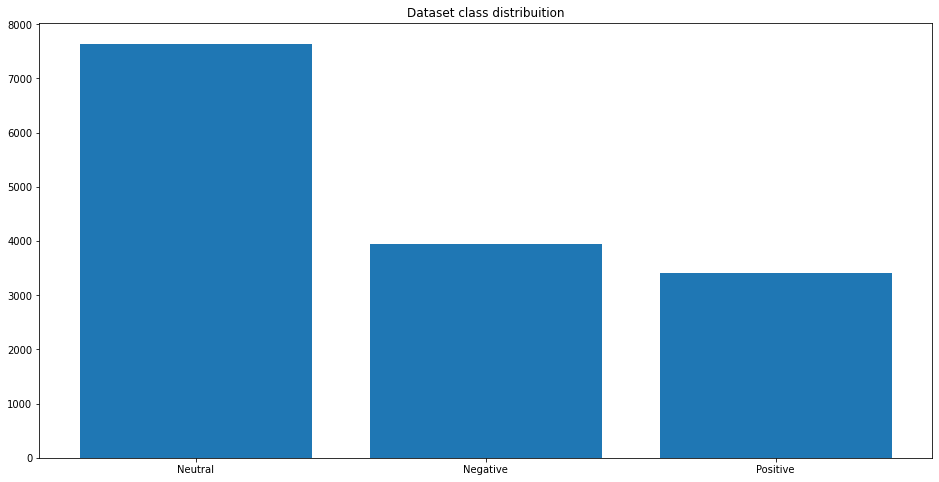

Top 10 positive terms


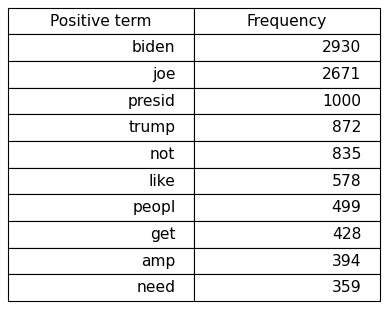

Top 10 negative terms


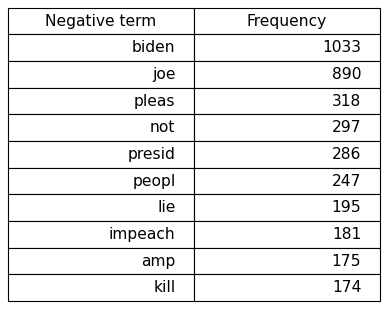

Top 10 neutral terms


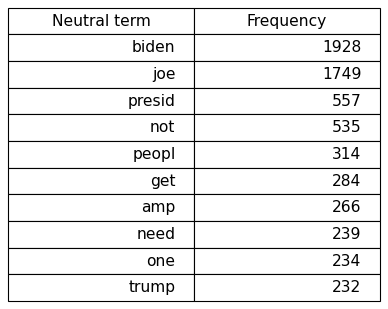

In [76]:
# plots dstribution and common words
target_cnt = tweetsDf_copy.target.value_counts()
plt.figure(figsize=(16,8))
plt.bar(["Neutral", "Negative","Positive"], target_cnt.values)
plt.title("Dataset class distribuition")
plt.show()

top_terms(*count_terms(tweetsDf_copy), 10)

count_all_natural = Counter()  
for index, text in enumerate(tweetsDf_copy.text):
    if tweetsDf_copy.iloc[index].target == -1:
      count_all_natural.update(text) 

natural_data = [list(x) for x in count_all_natural.most_common(10)]
print(f"Top {10} neutral terms")
draw_table(natural_data, 'Neutral')

# Question 4

### Remove Neutral Tweets

In [80]:
# remove neutral words
tweetsDf_copy_filtered =  tweetsDf_copy[tweetsDf_copy.target != -1]
tweetsDf_copy_filtered.reset_index(inplace=True)
tweetsDf_copy_filtered.target.value_counts()

0    3949
1    3408
Name: target, dtype: int64

### Prediction using The Best Model from Question 2

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


              precision    recall  f1-score   support

           0       0.69      0.60      0.65      3949
           1       0.60      0.69      0.64      3408

    accuracy                           0.64      7357
   macro avg       0.65      0.65      0.64      7357
weighted avg       0.65      0.64      0.64      7357



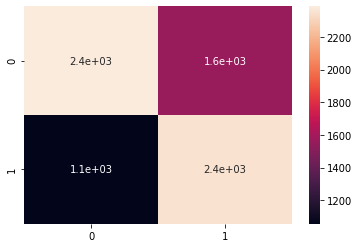

In [81]:
X_collected = tweetsDf_copy_filtered
y_collected = tweetsDf_copy_filtered['target']
X_collected.text = X_collected.text.apply(join_sentences)

# The best model which was trained in question 2 is the SVM+TD-IDF model which got 77% accuracy.
svm_collected_prediction = svm_model.predict(X_collected.text)
svm_accuracy_collected = accuracy_score(y_collected, svm_collected_prediction)

print(classification_report(y_collected, svm_collected_prediction))
svm_cm_collected = confusion_matrix(y_collected, svm_collected_prediction)
sns.heatmap(svm_cm_collected, annot=True)
print("=====================") 

# Question 5

### Tweets Aggregation

In [82]:
# count number of tweets at each day
def count_daily_tweets():
  count_tweets_per_day = {}
  for index,row in tweetsDf_copy.iterrows():
    date = row['date']
    if date in count_tweets_per_day:
      count_tweets_per_day[date] = count_tweets_per_day[date] + 1
    else:
      count_tweets_per_day[date] = 1
  return count_tweets_per_day

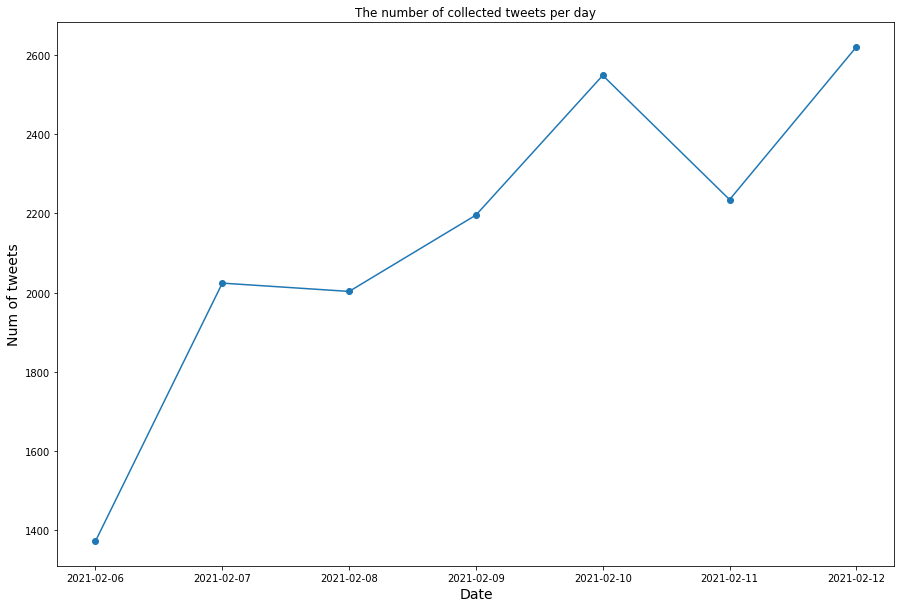

In [83]:
# plot graph of number of tweets per day
def graph_count_per_date(data, title, y_title):
    data = nltk.collections.OrderedDict(sorted(data.items()))
#     fig,ax = plt.subplots()
    plt.figure(figsize=(15, 10))
    plt.plot(list(data.keys()), list(data.values()),marker='o')
    plt.ylabel(y_title,fontsize=14)
    plt.xlabel('Date',fontsize=14)
    plt.title(title)
    plt.show()

daily_tweets_counter = count_daily_tweets()
graph_count_per_date(daily_tweets_counter, title = 'The number of collected tweets per day' , y_title = 'Num of tweets')

### Sentiment Classification 

In [84]:
X_collected_all = tweetsDf_copy
X_collected_all.text = X_collected_all.text.apply(join_sentences)

# The best model which was trained in question 2 is the SVM+TD-IDF model which got 77% accuracy.
svm_collected_prediction_all = svm_model.predict(X_collected_all.text)
X_collected_all["SVM predictions"] = svm_collected_prediction_all

In [85]:
count_positive_per_day = {}

# count number of positive tweets at each day
def count_daily_positive(data):
    for index, row in data.iterrows():
        if row["SVM predictions"] == 1:
            date = row['date']
            if date in count_positive_per_day:
                count_positive_per_day[date] = count_positive_per_day[date] + 1
            else:
                count_positive_per_day[date] = 1

In [86]:
positive_ratio_per_day = {}

# calculate the ratio of positive tweets at each day
def calculate_positive_ratio(data):
  for day in count_positive_per_day:
    positive_ratio_per_day[day] = np.divide(count_positive_per_day[day], daily_tweets_counter[day])

In [87]:
count_daily_positive(X_collected_all)
calculate_positive_ratio(tweetsDf_copy)

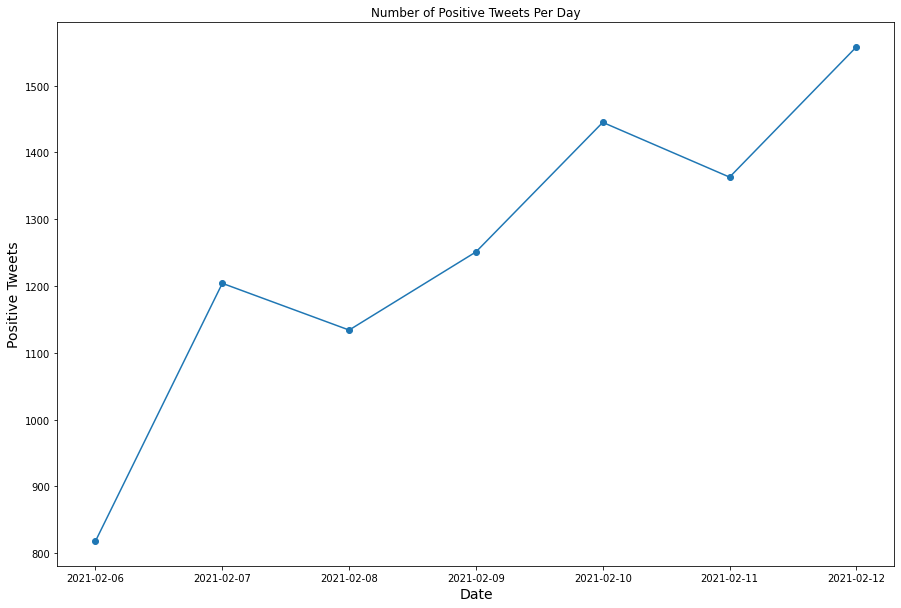

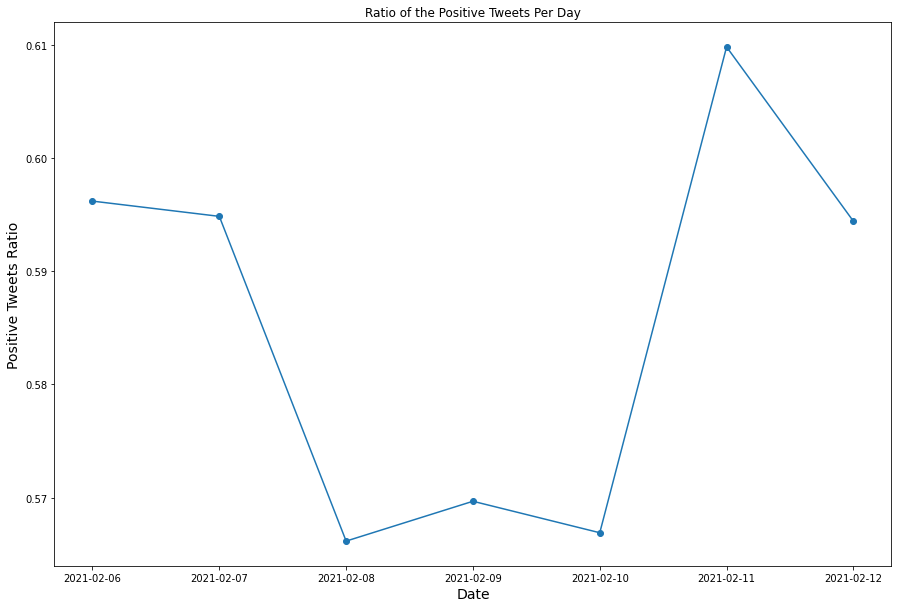

In [88]:
graph_count_per_date(count_positive_per_day, title="Number of Positive Tweets Per Day", y_title="Positive Tweets")
graph_count_per_date(positive_ratio_per_day, title="Ratio of the Positive Tweets Per Day", y_title="Positive Tweets Ratio")

### Google Trends

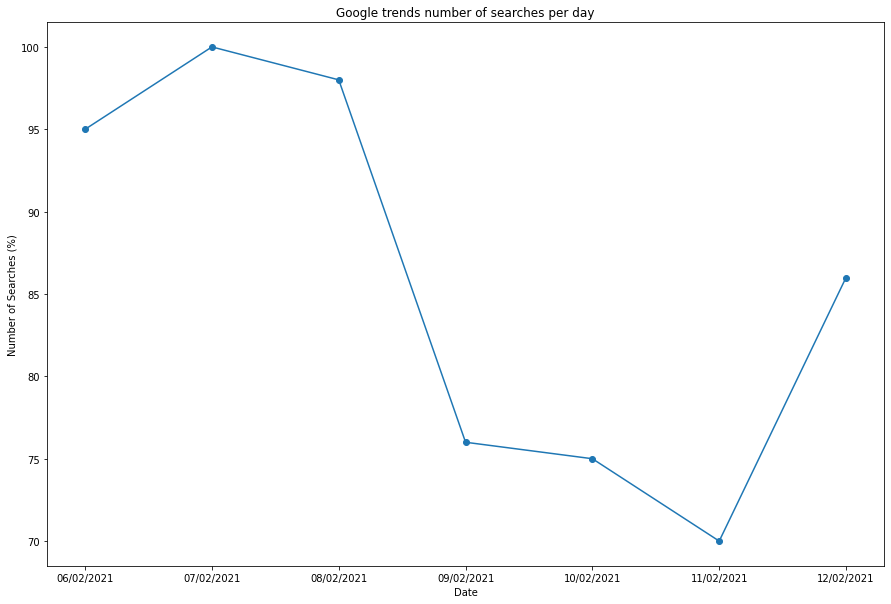

In [89]:
#import num of searches per date and hour
google_trend = pd.read_csv(google_trends_path, header=None)
google_trend.columns = ['date', 'num_of_searches']

x = []
for i in range(google_trend['date'].size):
    x.append(google_trend['date'][i])
y = google_trend['num_of_searches']
plt.figure(figsize=(15, 10))
plt.plot(x, y,marker='o')
plt.xlabel('Date')
plt.ylabel('Number of Searches (%)')
plt.title('Google trends number of searches per day')
plt.show()

### Comparing + Pearson Correlation

In [90]:
# dataframe for comparison
all_data = pd.DataFrame()
all_data['date'] = ['6-2-2021', '7-2-2021','8-2-2021','9-2-2021','10-2-2021','11-2-2021','12-2-2021']
all_data['count_tweets_per_day'] = count_daily_tweets().values()
all_data['count_positive_per_day'] = positive_ratio_per_day.values()
all_data['num_of_searches_per_day'] = google_trend['num_of_searches']
display(all_data)

,date,count_tweets_per_day,count_positive_per_day,num_of_searches_per_day
0,6-2-2021,1372,0.596210,95
1,7-2-2021,2024,0.594862,100
2,8-2-2021,2003,0.566151,98
3,9-2-2021,2196,0.569672,76
4,10-2-2021,2549,0.566889,75
5,11-2-2021,2235,0.609843,70
6,12-2-2021,2621,0.594430,86


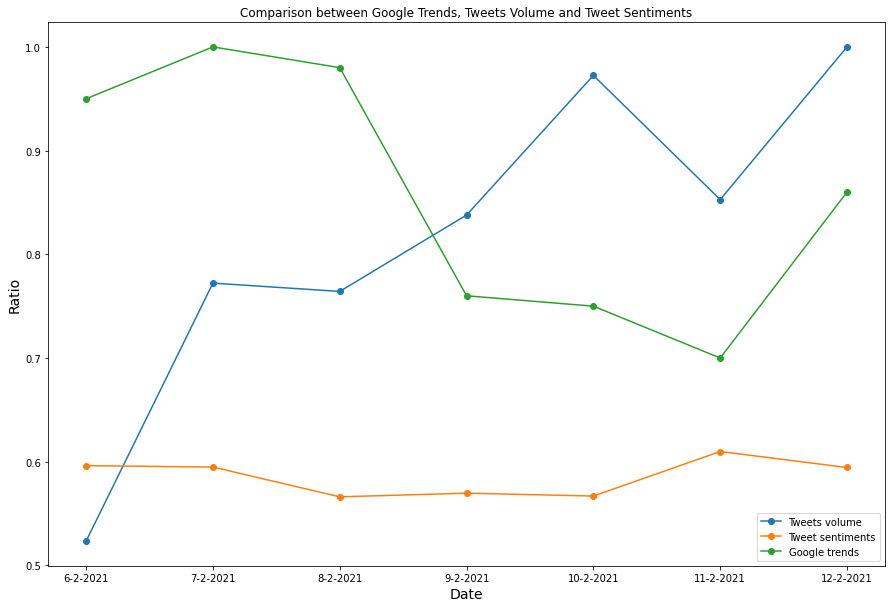

In [91]:
# plot all graphs in order to compare 
count_tweets_per_day_normalized = list(all_data['count_tweets_per_day'] / 2621)
num_of_searches_per_day_normalized = list(all_data['num_of_searches_per_day'] / 100)

plt.figure(figsize=(15, 10))
plt.plot(list(all_data['date']), count_tweets_per_day_normalized, marker='o')
plt.plot(list(all_data['date']), list(all_data['count_positive_per_day']), marker='o')
plt.plot(list(all_data['date']), num_of_searches_per_day_normalized, marker='o')

plt.ylabel("Ratio",fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.title("Comparison between Google Trends, Tweets Volume and Tweet Sentiments")
plt.legend(['Tweets volume', 'Tweet sentiments', 'Google trends'])
plt.show()

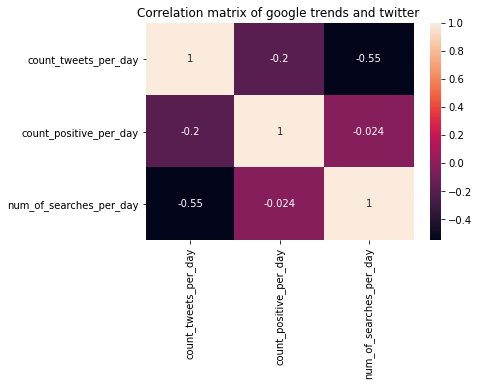

In [92]:
# compute pearson correlation between the different dolumns
corrMatrix = all_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation matrix of google trends and twitter ")

plt.show()